<a href="https://colab.research.google.com/github/aiml40/engr521/blob/FinalModel/UT_POD_Project_pytorchFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Develop UT inspection POD using Convolutional Neural Network (CNN)

## Import libraries



In [ ]:
#Alex's addition to test github

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset, Subset

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import datetime
import pytz
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)
##Activate GPU if avaiable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
print("^^^^ if cuda is printed, we are using the GPU!")

Libraries imported - ready to use PyTorch 2.6.0+cu124
cuda
^^^^ if cuda is printed, we are using the GPU!


## Explore the data

We'll train a CNN-based classification model that can classify images of geometric shapes. Let's take a look at the classes of shape the model needs to identify.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def open_pickle_file(file_path):
    """
    Opens and reads  pickle file

    Args:
        file_path (str): The path to the pickle file.

    Returns:
        object: The Python object stored in the pickle file, or None if an error occurs.
    """
    try:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
file_path = '/content/drive/MyDrive/dataset.pkl'
#file_path = '/content/drive/MyDrive/engr521_dataset/dataset.pkl'

#file_path = '/content/drive/MyDrive/engr521_dataset/dataset_Haar_Full.pkl'
xs,ys = open_pickle_file(file_path)

if xs.any():
    print("Data loaded successfully:")
    print(xs.shape,ys.shape)


Error: File not found at /content/drive/MyDrive/dataset.pkl


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
with open("/content/drive/MyDrive/engr521_dataset/dataset.pkl", "rb") as f:
  xs, ys = pickle.load(f)
print(xs.shape)
print(ys.shape)

(20010, 1, 256, 256)
(20010, 2)


In [ ]:
def load_batchdataset (x,y,batch_size, testfraction):


  """
  Opens and reads  pickle file

    Args:
        x (numpy array): Features array.
        y (numpy array): labels and  defect size array.
        batch_size (int): batch size
        testfraction(real): % data for testing

    Returns:
        train_loader: Pytorch loader
        test_loader : Pytorch loader.
  """

  # Split into training and testing datasets
  xsT, xsV, ysT, ysV = train_test_split(x, y, test_size=testfraction, random_state=42)

  # === Training data ====

  X_train = torch.from_numpy(xsT).float()
  y_train = torch.from_numpy(ysT[:,0]).float()
  y_train_defectsize = torch.from_numpy(ysT[:,1]).float()

  # === Testing data ====

  X_test = torch.from_numpy(xsV).float()
  y_test = torch.from_numpy(ysV[:,0]).float()
  y_test_defectsize = torch.from_numpy(ysV[:,1]).float()

  print(f"X_train type: {type(X_train)}")
  print(f"X_train size: {X_train.size(),X_train.shape}")
  print()
  print(f"y_train type: {type(y_train)}")
  print(f"y_train size: {y_train.size(),y_train.shape}")
  print()
  print(f"y_train defect type: {type(y_train_defectsize)}")
  print(f"y_train defect  size: {y_train_defectsize.size(),y_train_defectsize.shape}")

  # Use data tensors to build PyTorch Datasets.
  train_dataset = TensorDataset(X_train, y_train, y_train_defectsize)
  test_dataset = TensorDataset(X_test, y_test, y_test_defectsize)

  # Use Datasets to build PyTorch DataLoaders.

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  # Note: DataLoaders are iterable, where each iteration yields a batch of data.
  # Grab the first batch from the training loader to see dimensions.
  batch_images, batch_labels, batch_damage = next(iter(train_loader))
  print(f"batch_images size: {batch_images.size()}")
  print(f"batch_labels size: {batch_labels.size()}")
  print(f"batch_ldamage size: {batch_damage.size()}")
  return train_loader,test_loader


## Load data



In [ ]:
train_loader,test_loader = load_batchdataset (xs,ys,32, 0.5)

X_train type: <class 'torch.Tensor'>
X_train size: (torch.Size([10005, 1, 256, 256]), torch.Size([10005, 1, 256, 256]))

y_train type: <class 'torch.Tensor'>
y_train size: (torch.Size([10005]), torch.Size([10005]))

y_train defect type: <class 'torch.Tensor'>
y_train defect  size: (torch.Size([10005]), torch.Size([10005]))
batch_images size: torch.Size([32, 1, 256, 256])
batch_labels size: torch.Size([32])
batch_ldamage size: torch.Size([32])


## Define the CNN



In [ ]:
#works with channels_first format (i.e., shape [batch, channels, height, width]), unlike Keras which defaults to channels_last.
###
class UTModel(nn.Module):
    def __init__(self, w, h, window):
        super(UTModel, self).__init__()
        """
        In CNNs the actual values in the kernels are the weights your network will learn during training: your network will learn what structures are important for prediction.
        With CNN we are no longer flattening our data, so what are our “features”? Our features are called “channels”
        in_channels: how many features are we passing in. Our features are our colour bands, in greyscale, we have 1 feature, in colour, we have 3 channels.
        out_channels: how many kernels do we want to use. Analogous to the number of hidden nodes in a hidden layer of a fully connected network.(How many filters you use in each layer)
        kernel_size: the size of the kernel. e.g. 3x3 (size of the filter)
        stride: the “step-size” of the kernel.
        padding: the number of pixels we should pad to the outside of the image so we can get edge pixels.
        We use “pooling layers” to reduce the shape of our image as it’s passing through the network.
        So when we eventually torch.nn.Flatten(), we’ll have less features in that flattened layer!
        """
        # Shared CNN encoder
        self.features = nn.Sequential(
            # Initial MaxPooling over the "height" dimension
            #If stride is not specified, it defaults to kernel_size
            nn.MaxPool2d((window, 1), stride=(window, 1), padding=0), #reduce the height of our image by dividing it by window(7) as it’s passing through the network (256x256 to 36x256).
            # Conv Block 1
            # First 2D convolutional layer, taking in 1 input channel (image),
            # outputting 96 convolutional features, with a square kernel size of 3
            nn.Conv2d(1, 96, 3, padding=1),
            nn.ReLU(),
            #nn.Tanh(),
            #nn.MaxPool2d((window, 1), stride=(window, 1), padding=0), #reduce the height of our image by dividing it by window(7) as it’s passing through the network (256x256 to 36x256).
            nn.Conv2d(96, 64, 3, padding=1),  # 96 input channels, output 64 convulation features with a square kernal size 3.
            nn.ReLU(),
            #nn.Tanh(),
            nn.MaxPool2d((2, 8), padding=(1, 3)), #reduce the image size by dividing it by (2,8) as it’s passing through the network (36x256 to 18x32).
            # Conv Block 2
            nn.Conv2d(64, 48, 3, padding=1), # 64 input channels, output 48 convulation features with a square kernal size 3.
            nn.ReLU(),
            #nn.Tanh(),
            nn.Conv2d(48, 32, 3, padding=1),# 48 input channels, output 32 convulation features with a square kernal size 3.
            nn.ReLU(),
            #nn.Tanh(),
            nn.MaxPool2d((3, 4), padding=(1, 1)) #reduce the image size by dividing it by (3,4) as it’s passing through the network (18x32 to 6 x 8).
        )

        # Flatten
        self.flatten = nn.Flatten()

        # Fully connected shared
        self.shared_fc = nn.Sequential(
            nn.Linear(1792, 14),  # After Pooling layers image size is 6 x 8 and after last conv layer the output channels are 32; 6 x 8 x 32 = 1536
            nn.ReLU()
        )

        # Heads
        self.class_head = nn.Linear(14, 1)  # single output for binary class
        #self.reg_head = nn.Linear(14, 1)    # output for defect size

    def forward(self, x):
        x = self.features(x)
        #print("Shape after CNN:",x.shape)
        x = self.flatten(x)
        #print("Shape after flatten:",x.shape)
        x = self.shared_fc(x)

        class_logit = self.class_head(x)  # for BCEWithLogitsLoss
        #reg_output = self.reg_head(x)
        #return class_logit, reg_output
        return class_logit


In [ ]:
def logits_to_sigmoid_probs(logits):
    return torch.sigmoid(logits)  # shape: [batch_size]

def plot_single_prob_vs_defect_size(probs, defect_sizes, title=""):
    plt.figure(figsize=(8, 5))
    plt.scatter(defect_sizes, probs, alpha=0.6, c=probs, cmap='coolwarm')
    plt.xlabel("Defect Size", fontsize=16)
    plt.ylabel("Probability of detection", fontsize=16)
    plt.title(title, fontsize=18)
    cbar = plt.colorbar()
    cbar.set_label('Probability', size=16)
    #plt.colorbar(label="Probability")
    plt.grid(True)
    plt.show()

## Train and Test the model


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1


Epochs:   0%|          | 1/500 [00:15<2:08:55, 15.50s/it]

Epoch 2


Epochs:   0%|          | 2/500 [00:29<2:02:09, 14.72s/it]

Epoch 3


Epochs:   1%|          | 3/500 [00:43<2:00:00, 14.49s/it]

Epoch 4


Epochs:   1%|          | 4/500 [00:58<1:59:21, 14.44s/it]

Epoch 5


Epochs:   1%|          | 5/500 [01:12<1:59:10, 14.45s/it]

Epoch 6


Epochs:   1%|          | 6/500 [01:27<1:58:59, 14.45s/it]

Epoch 7


Epochs:   1%|▏         | 7/500 [01:41<1:59:05, 14.49s/it]

Epoch 8


Epochs:   2%|▏         | 8/500 [01:56<1:59:25, 14.56s/it]

Epoch 9


Epochs:   2%|▏         | 9/500 [02:11<1:59:46, 14.64s/it]

Epoch 10


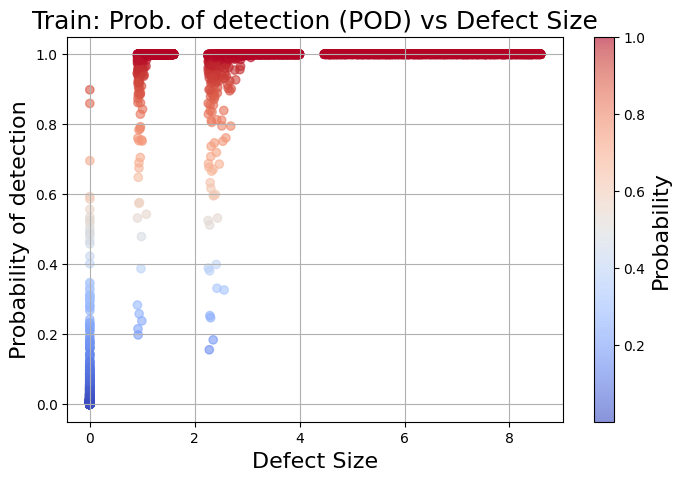

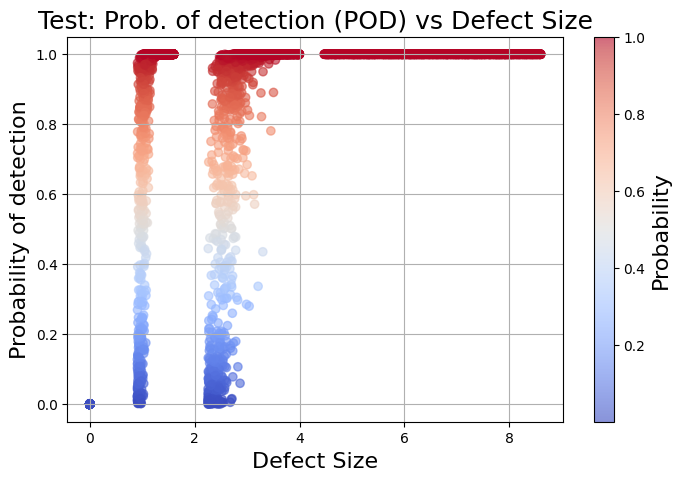

Epochs:   2%|▏         | 10/500 [02:26<2:01:20, 14.86s/it]

Epoch 11


Epochs:   2%|▏         | 11/500 [02:41<2:00:51, 14.83s/it]

Epoch 12


Epochs:   2%|▏         | 12/500 [02:56<2:00:21, 14.80s/it]

Epoch 13


Epochs:   3%|▎         | 13/500 [03:10<1:59:55, 14.77s/it]

Epoch 14


Epochs:   3%|▎         | 14/500 [03:25<1:59:36, 14.77s/it]

Epoch 15


Epochs:   3%|▎         | 15/500 [03:40<1:59:18, 14.76s/it]

Epoch 16


Epochs:   3%|▎         | 16/500 [03:55<1:59:05, 14.76s/it]

Epoch 17


Epochs:   3%|▎         | 17/500 [04:09<1:58:57, 14.78s/it]

Epoch 18


Epochs:   4%|▎         | 18/500 [04:24<1:58:34, 14.76s/it]

Epoch 19


Epochs:   4%|▍         | 19/500 [04:39<1:58:18, 14.76s/it]

Epoch 20


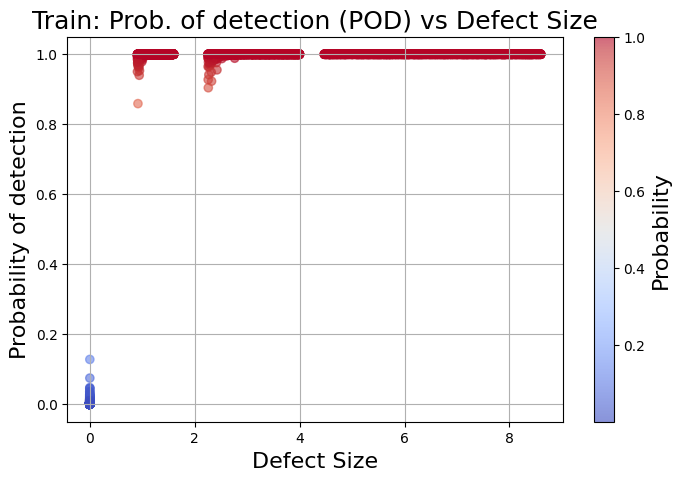

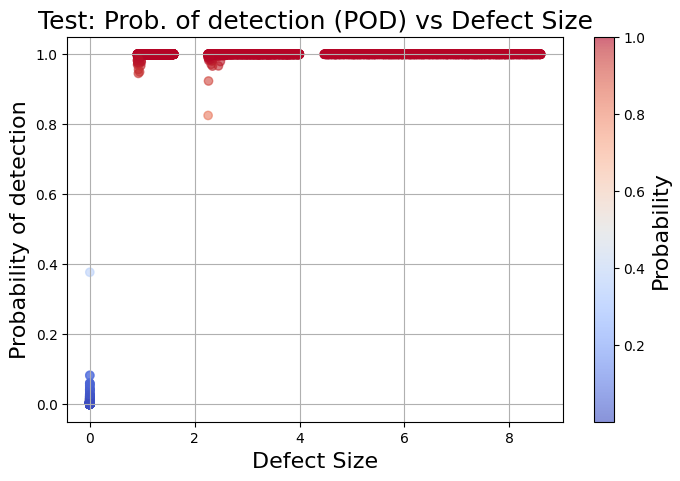

Epochs:   4%|▍         | 20/500 [04:54<1:59:30, 14.94s/it]

Epoch 21


Epochs:   4%|▍         | 21/500 [05:09<1:58:43, 14.87s/it]

Epoch 22


Epochs:   4%|▍         | 22/500 [05:24<1:58:14, 14.84s/it]

Epoch 23


Epochs:   5%|▍         | 23/500 [05:39<1:57:51, 14.82s/it]

Epoch 24


Epochs:   5%|▍         | 24/500 [05:53<1:57:20, 14.79s/it]

Epoch 25


Epochs:   5%|▌         | 25/500 [06:08<1:57:00, 14.78s/it]

Epoch 26


Epochs:   5%|▌         | 26/500 [06:23<1:56:37, 14.76s/it]

Epoch 27


Epochs:   5%|▌         | 27/500 [06:37<1:56:21, 14.76s/it]

Epoch 28


Epochs:   6%|▌         | 28/500 [06:52<1:56:24, 14.80s/it]

Epoch 29


Epochs:   6%|▌         | 29/500 [07:07<1:55:57, 14.77s/it]

Epoch 30


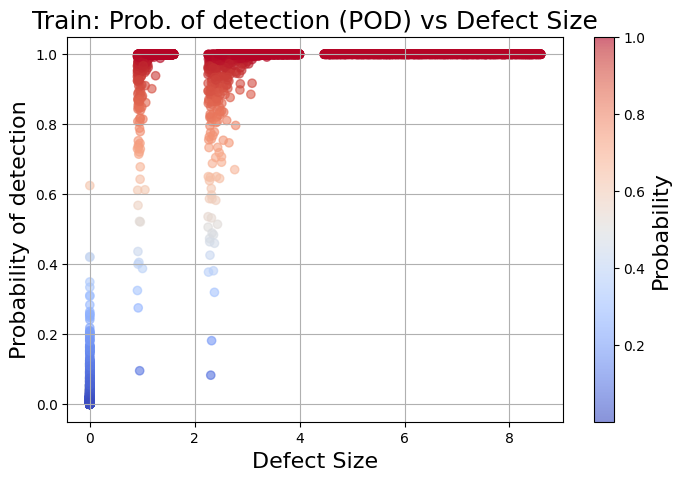

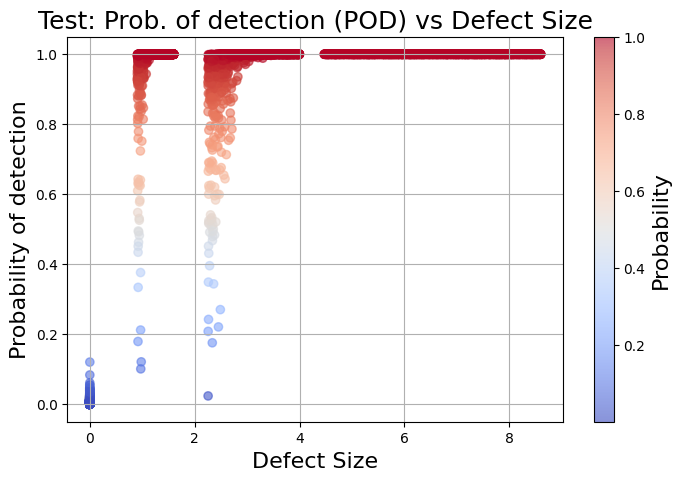

Epochs:   6%|▌         | 30/500 [07:22<1:57:09, 14.96s/it]

Epoch 31


Epochs:   6%|▌         | 31/500 [07:37<1:56:08, 14.86s/it]

Epoch 32


Epochs:   6%|▋         | 32/500 [07:52<1:55:19, 14.79s/it]

Epoch 33


Epochs:   7%|▋         | 33/500 [08:06<1:54:38, 14.73s/it]

Epoch 34


Epochs:   7%|▋         | 34/500 [08:21<1:54:03, 14.69s/it]

Epoch 35


Epochs:   7%|▋         | 35/500 [08:35<1:53:31, 14.65s/it]

Epoch 36


Epochs:   7%|▋         | 36/500 [08:50<1:53:09, 14.63s/it]

Epoch 37


Epochs:   7%|▋         | 37/500 [09:05<1:52:51, 14.63s/it]

Epoch 38


Epochs:   8%|▊         | 38/500 [09:19<1:52:30, 14.61s/it]

Epoch 39


Epochs:   8%|▊         | 39/500 [09:34<1:52:11, 14.60s/it]

Epoch 40


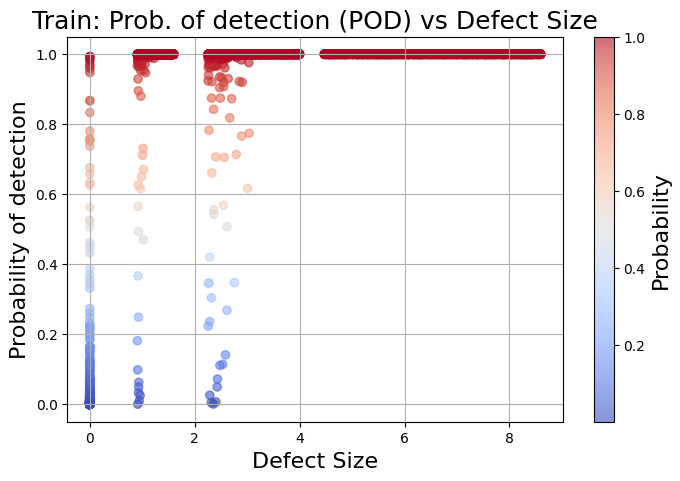

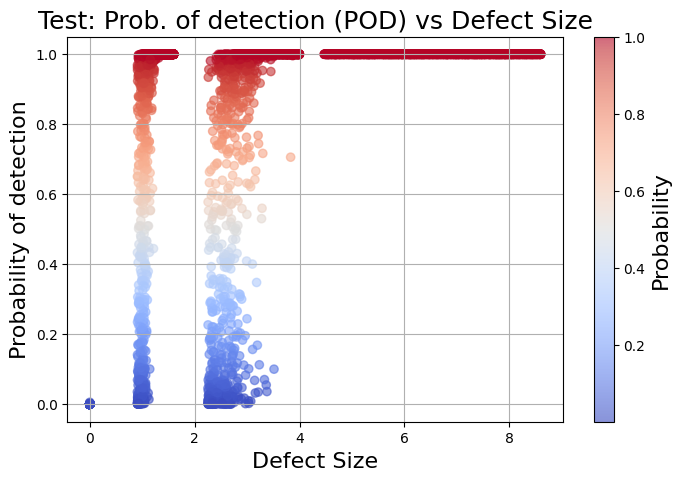

Epochs:   8%|▊         | 40/500 [09:49<1:53:22, 14.79s/it]

Epoch 41


Epochs:   8%|▊         | 41/500 [10:04<1:52:38, 14.72s/it]

Epoch 42


Epochs:   8%|▊         | 42/500 [10:18<1:52:01, 14.67s/it]

Epoch 43


Epochs:   9%|▊         | 43/500 [10:33<1:51:27, 14.63s/it]

Epoch 44


Epochs:   9%|▉         | 44/500 [10:47<1:51:03, 14.61s/it]

Epoch 45


Epochs:   9%|▉         | 45/500 [11:02<1:50:45, 14.60s/it]

Epoch 46


Epochs:   9%|▉         | 46/500 [11:16<1:50:26, 14.59s/it]

Epoch 47


Epochs:   9%|▉         | 47/500 [11:31<1:50:07, 14.59s/it]

Epoch 48


Epochs:  10%|▉         | 48/500 [11:46<1:50:00, 14.60s/it]

Epoch 49


Epochs:  10%|▉         | 49/500 [12:00<1:49:44, 14.60s/it]

Epoch 50


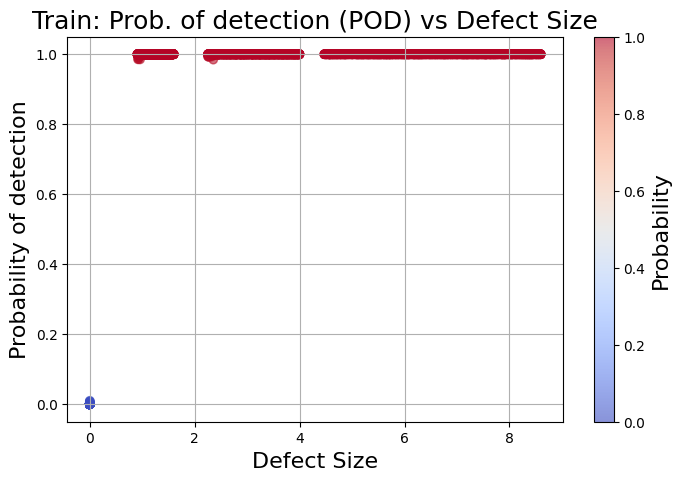

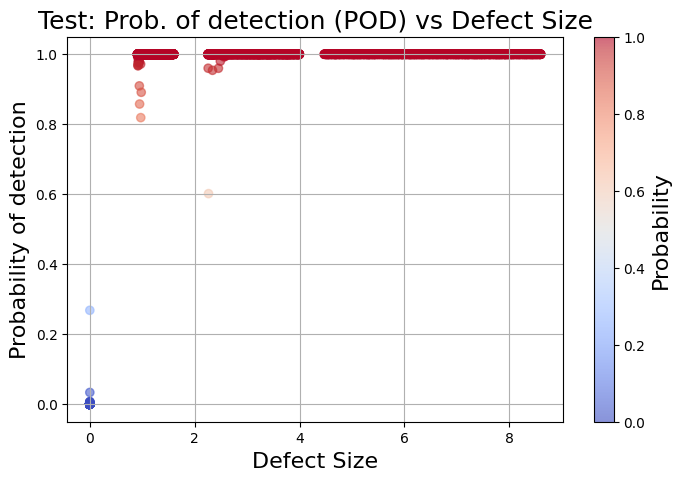

Epochs:  10%|█         | 50/500 [12:15<1:50:45, 14.77s/it]

Epoch 51


Epochs:  10%|█         | 51/500 [12:30<1:50:27, 14.76s/it]

Epoch 52


Epochs:  10%|█         | 52/500 [12:45<1:50:13, 14.76s/it]

Epoch 53


Epochs:  11%|█         | 53/500 [13:00<1:49:47, 14.74s/it]

Epoch 54


Epochs:  11%|█         | 54/500 [13:14<1:49:36, 14.75s/it]

Epoch 55


Epochs:  11%|█         | 55/500 [13:29<1:49:18, 14.74s/it]

Epoch 56


Epochs:  11%|█         | 56/500 [13:44<1:49:12, 14.76s/it]

Epoch 57


Epochs:  11%|█▏        | 57/500 [13:59<1:49:03, 14.77s/it]

Epoch 58


Epochs:  12%|█▏        | 58/500 [14:13<1:48:46, 14.77s/it]

Epoch 59


Epochs:  12%|█▏        | 59/500 [14:28<1:48:27, 14.76s/it]

Epoch 60


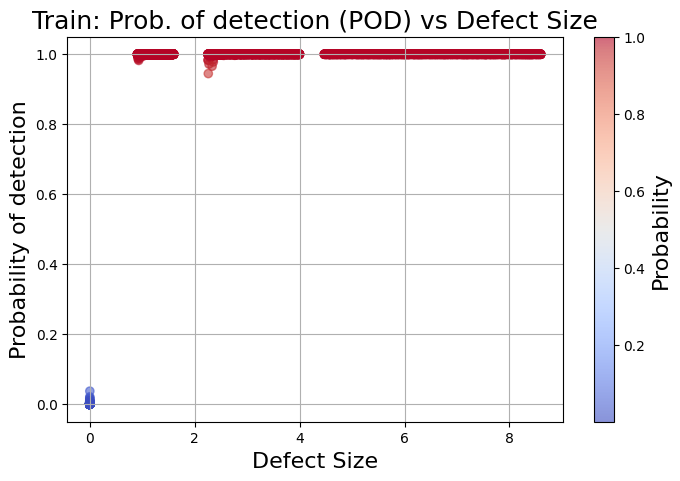

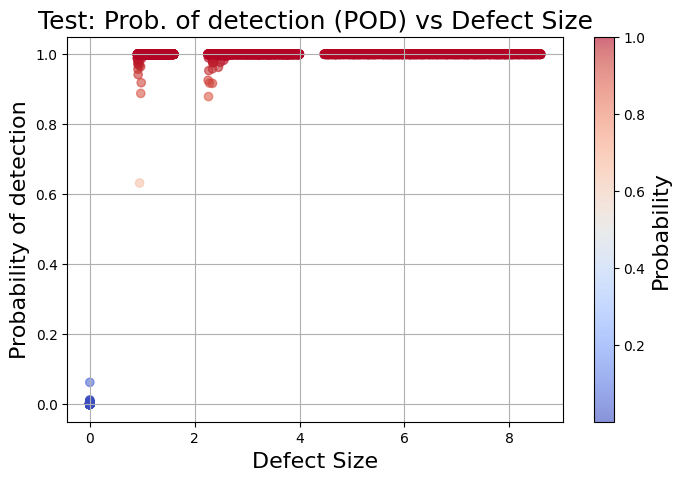

Epochs:  12%|█▏        | 60/500 [14:43<1:49:32, 14.94s/it]

Epoch 61


Epochs:  12%|█▏        | 61/500 [14:58<1:48:58, 14.89s/it]

Epoch 62


Epochs:  12%|█▏        | 62/500 [15:13<1:48:29, 14.86s/it]

Epoch 63


Epochs:  13%|█▎        | 63/500 [15:28<1:47:50, 14.81s/it]

Epoch 64


Epochs:  13%|█▎        | 64/500 [15:42<1:47:28, 14.79s/it]

Epoch 65


Epochs:  13%|█▎        | 65/500 [15:57<1:47:32, 14.83s/it]

Epoch 66


Epochs:  13%|█▎        | 66/500 [16:12<1:47:06, 14.81s/it]

Epoch 67


Epochs:  13%|█▎        | 67/500 [16:27<1:46:29, 14.76s/it]

Epoch 68


Epochs:  14%|█▎        | 68/500 [16:42<1:46:10, 14.75s/it]

Epoch 69


Epochs:  14%|█▍        | 69/500 [16:56<1:45:44, 14.72s/it]

Epoch 70


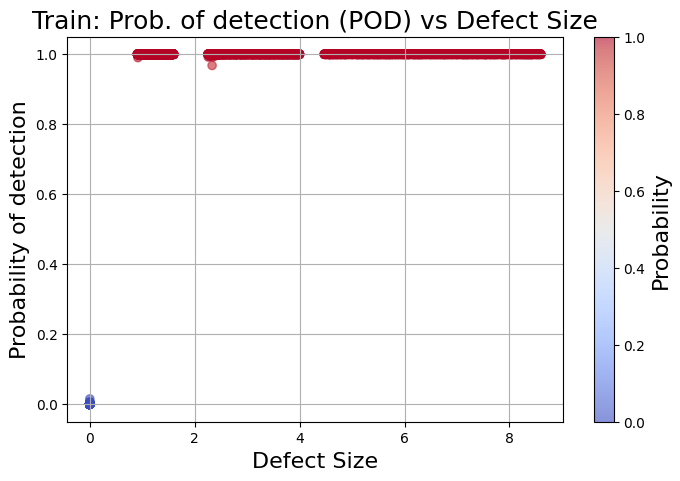

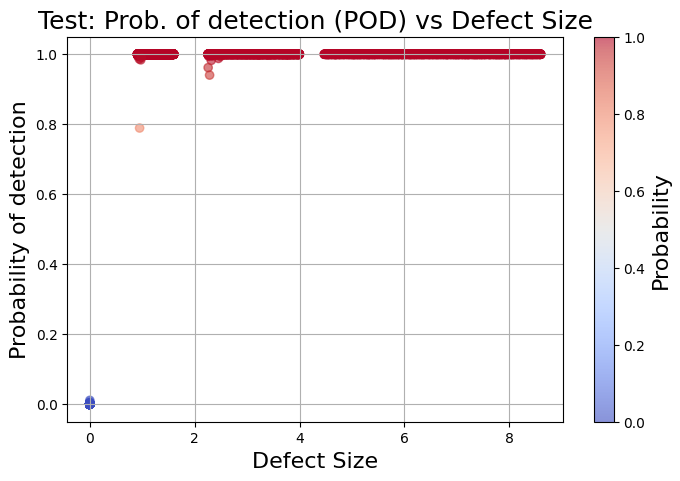

Epochs:  14%|█▍        | 70/500 [17:12<1:46:54, 14.92s/it]

Epoch 71


Epochs:  14%|█▍        | 71/500 [17:26<1:46:06, 14.84s/it]

Epoch 72


Epochs:  14%|█▍        | 72/500 [17:41<1:45:34, 14.80s/it]

Epoch 73


Epochs:  15%|█▍        | 73/500 [17:56<1:45:18, 14.80s/it]

Epoch 74


Epochs:  15%|█▍        | 74/500 [18:11<1:45:17, 14.83s/it]

Epoch 75


Epochs:  15%|█▌        | 75/500 [18:25<1:44:59, 14.82s/it]

Epoch 76


Epochs:  15%|█▌        | 76/500 [18:40<1:44:40, 14.81s/it]

Epoch 77


Epochs:  15%|█▌        | 77/500 [18:55<1:44:13, 14.78s/it]

Epoch 78


Epochs:  16%|█▌        | 78/500 [19:10<1:43:39, 14.74s/it]

Epoch 79


Epochs:  16%|█▌        | 79/500 [19:24<1:43:25, 14.74s/it]

Epoch 80


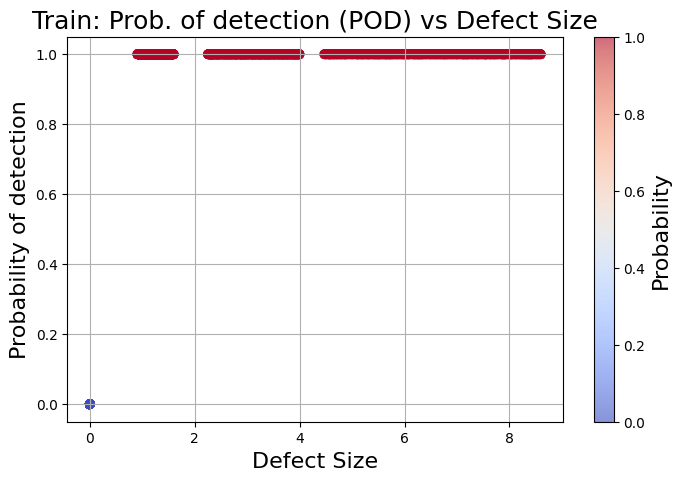

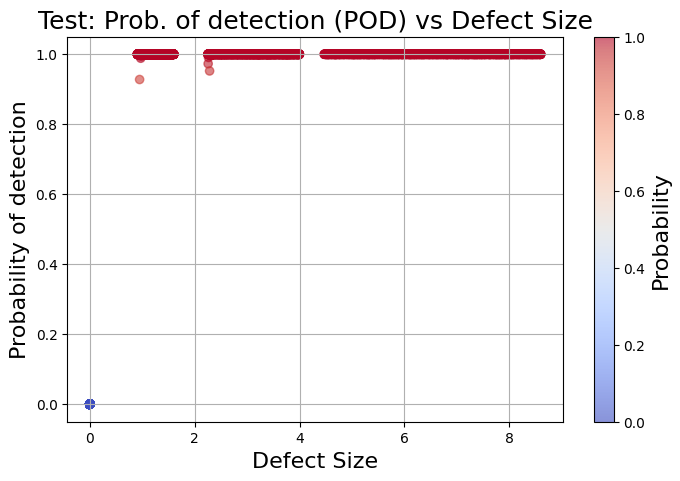

Epochs:  16%|█▌        | 80/500 [19:40<1:44:22, 14.91s/it]

Epoch 81


Epochs:  16%|█▌        | 81/500 [19:54<1:43:27, 14.82s/it]

Epoch 82


Epochs:  16%|█▋        | 82/500 [20:09<1:42:44, 14.75s/it]

Epoch 83


Epochs:  17%|█▋        | 83/500 [20:23<1:42:13, 14.71s/it]

Epoch 84


Epochs:  17%|█▋        | 84/500 [20:38<1:41:55, 14.70s/it]

Epoch 85


Epochs:  17%|█▋        | 85/500 [20:53<1:41:32, 14.68s/it]

Epoch 86


Epochs:  17%|█▋        | 86/500 [21:07<1:41:16, 14.68s/it]

Epoch 87


Epochs:  17%|█▋        | 87/500 [21:22<1:40:54, 14.66s/it]

Epoch 88


Epochs:  18%|█▊        | 88/500 [21:37<1:40:32, 14.64s/it]

Epoch 89


Epochs:  18%|█▊        | 89/500 [21:51<1:40:23, 14.66s/it]

Epoch 90


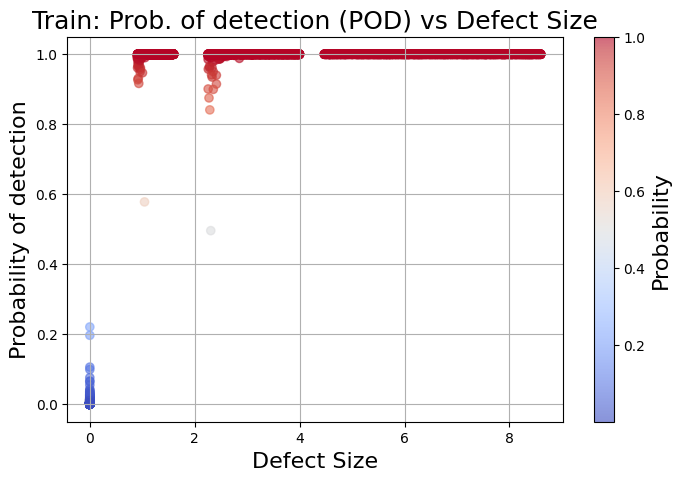

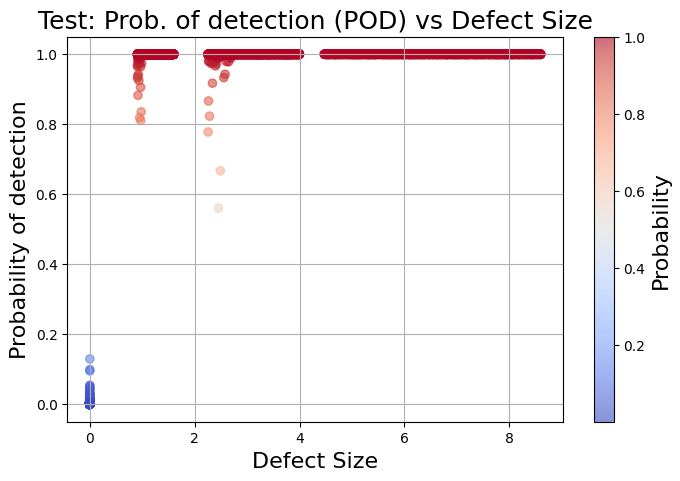

Epochs:  18%|█▊        | 90/500 [22:07<1:41:24, 14.84s/it]

Epoch 91


Epochs:  18%|█▊        | 91/500 [22:21<1:40:41, 14.77s/it]

Epoch 92


Epochs:  18%|█▊        | 92/500 [22:36<1:40:07, 14.72s/it]

Epoch 93


Epochs:  19%|█▊        | 93/500 [22:50<1:39:42, 14.70s/it]

Epoch 94


Epochs:  19%|█▉        | 94/500 [23:05<1:39:18, 14.68s/it]

Epoch 95


Epochs:  19%|█▉        | 95/500 [23:20<1:38:51, 14.65s/it]

Epoch 96


Epochs:  19%|█▉        | 96/500 [23:34<1:38:30, 14.63s/it]

Epoch 97


Epochs:  19%|█▉        | 97/500 [23:49<1:38:20, 14.64s/it]

Epoch 98


Epochs:  20%|█▉        | 98/500 [24:04<1:38:07, 14.65s/it]

Epoch 99


Epochs:  20%|█▉        | 99/500 [24:18<1:37:57, 14.66s/it]

Epoch 100


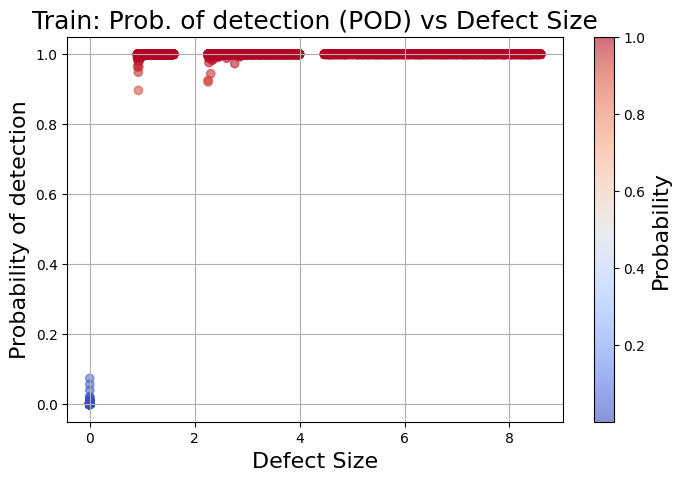

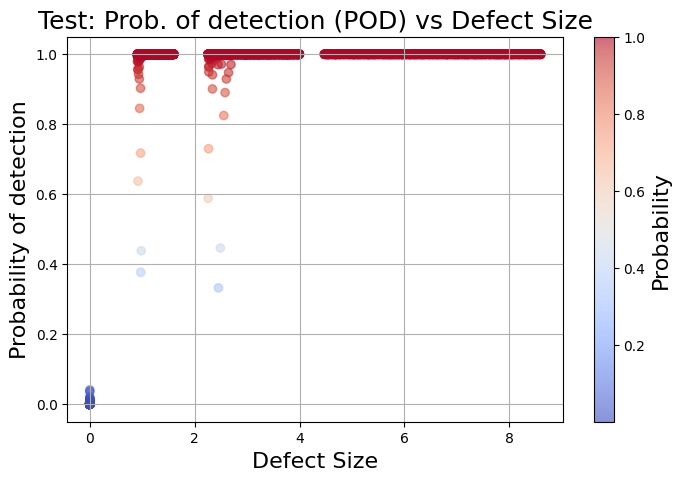

Epochs:  20%|██        | 100/500 [24:34<1:39:23, 14.91s/it]

Epoch 101


Epochs:  20%|██        | 101/500 [24:48<1:38:34, 14.82s/it]

Epoch 102


Epochs:  20%|██        | 102/500 [25:03<1:37:57, 14.77s/it]

Epoch 103


Epochs:  21%|██        | 103/500 [25:18<1:37:31, 14.74s/it]

Epoch 104


Epochs:  21%|██        | 104/500 [25:32<1:36:58, 14.69s/it]

Epoch 105


Epochs:  21%|██        | 105/500 [25:47<1:36:33, 14.67s/it]

Epoch 106


Epochs:  21%|██        | 106/500 [26:02<1:36:13, 14.65s/it]

Epoch 107


Epochs:  21%|██▏       | 107/500 [26:16<1:35:57, 14.65s/it]

Epoch 108


Epochs:  22%|██▏       | 108/500 [26:31<1:35:43, 14.65s/it]

Epoch 109


Epochs:  22%|██▏       | 109/500 [26:45<1:35:23, 14.64s/it]

Epoch 110


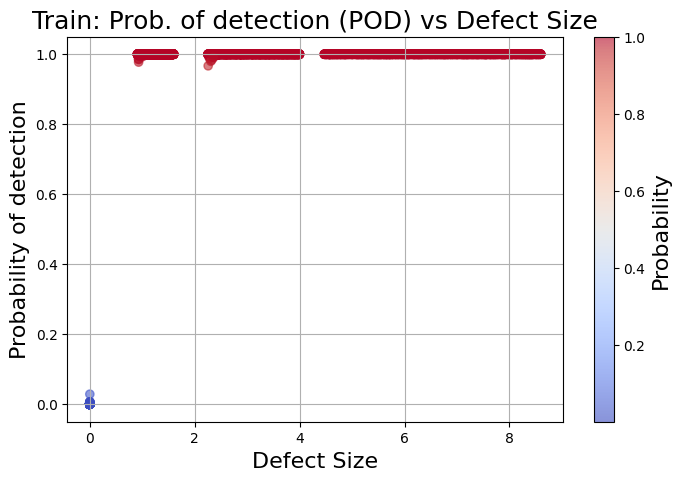

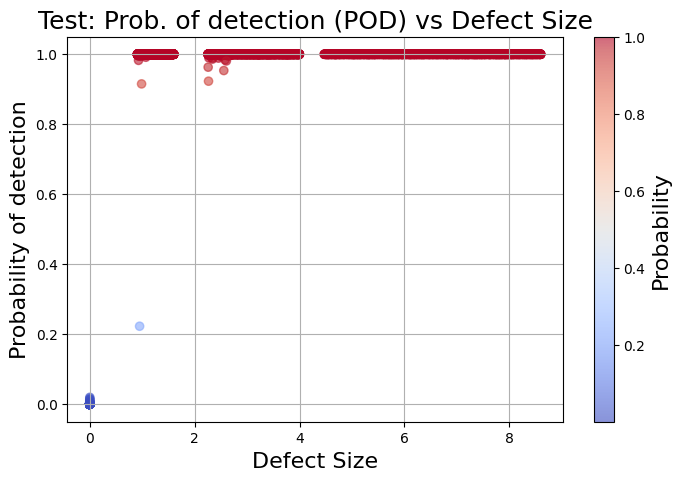

Epochs:  22%|██▏       | 110/500 [27:01<1:36:16, 14.81s/it]

Epoch 111


Epochs:  22%|██▏       | 111/500 [27:15<1:35:25, 14.72s/it]

Epoch 112


Epochs:  22%|██▏       | 112/500 [27:30<1:34:51, 14.67s/it]

Epoch 113


Epochs:  23%|██▎       | 113/500 [27:44<1:34:25, 14.64s/it]

Epoch 114


Epochs:  23%|██▎       | 114/500 [27:59<1:34:07, 14.63s/it]

Epoch 115


Epochs:  23%|██▎       | 115/500 [28:13<1:33:41, 14.60s/it]

Epoch 116


Epochs:  23%|██▎       | 116/500 [28:28<1:33:20, 14.58s/it]

Epoch 117


Epochs:  23%|██▎       | 117/500 [28:43<1:33:10, 14.60s/it]

Epoch 118


Epochs:  24%|██▎       | 118/500 [28:57<1:32:49, 14.58s/it]

Epoch 119


Epochs:  24%|██▍       | 119/500 [29:12<1:32:26, 14.56s/it]

Epoch 120


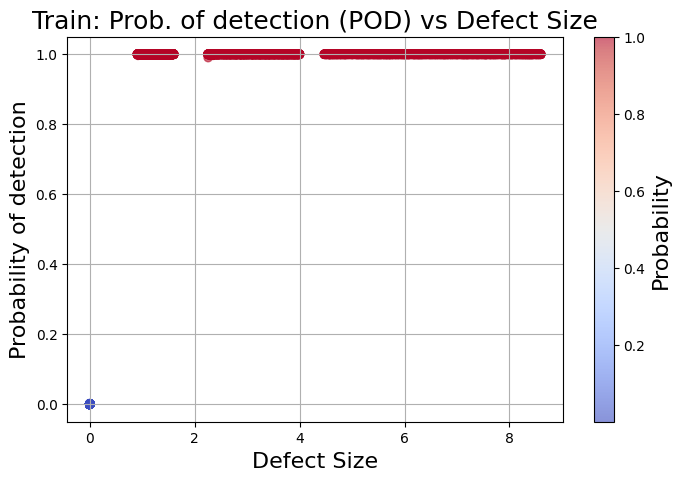

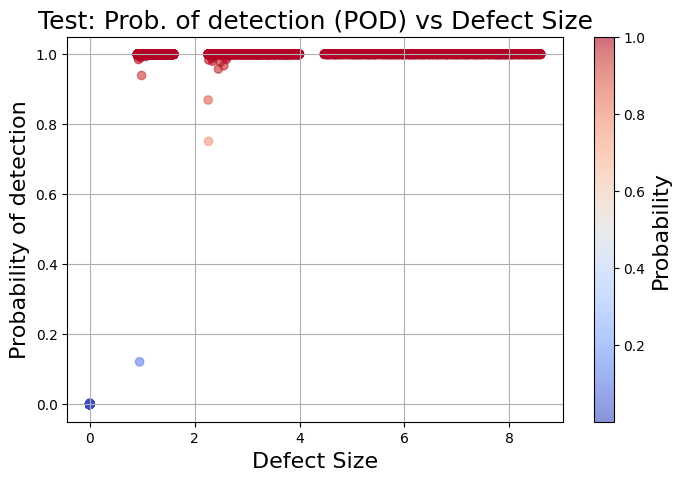

Epochs:  24%|██▍       | 120/500 [29:27<1:33:20, 14.74s/it]

Epoch 121


Epochs:  24%|██▍       | 121/500 [29:41<1:32:37, 14.66s/it]

Epoch 122


Epochs:  24%|██▍       | 122/500 [29:56<1:32:10, 14.63s/it]

Epoch 123


Epochs:  25%|██▍       | 123/500 [30:10<1:31:51, 14.62s/it]

Epoch 124


Epochs:  25%|██▍       | 124/500 [30:25<1:31:26, 14.59s/it]

Epoch 125


Epochs:  25%|██▌       | 125/500 [30:40<1:31:09, 14.58s/it]

Epoch 126


Epochs:  25%|██▌       | 126/500 [30:54<1:30:42, 14.55s/it]

Epoch 127


Epochs:  25%|██▌       | 127/500 [31:09<1:30:25, 14.55s/it]

Epoch 128


Epochs:  26%|██▌       | 128/500 [31:23<1:30:04, 14.53s/it]

Epoch 129


Epochs:  26%|██▌       | 129/500 [31:38<1:30:10, 14.58s/it]

Epoch 130


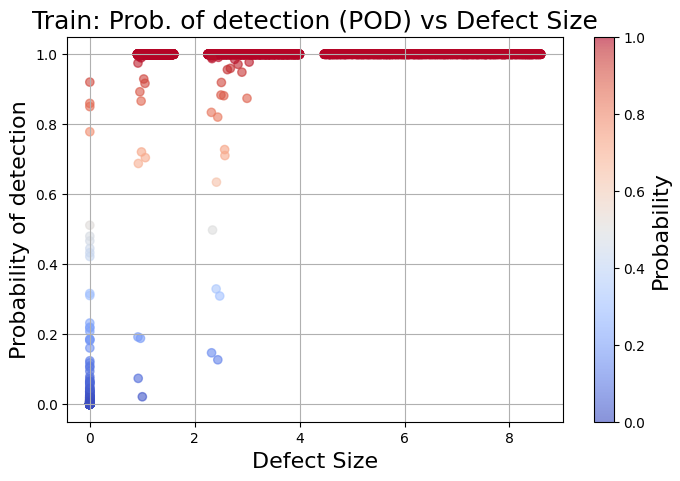

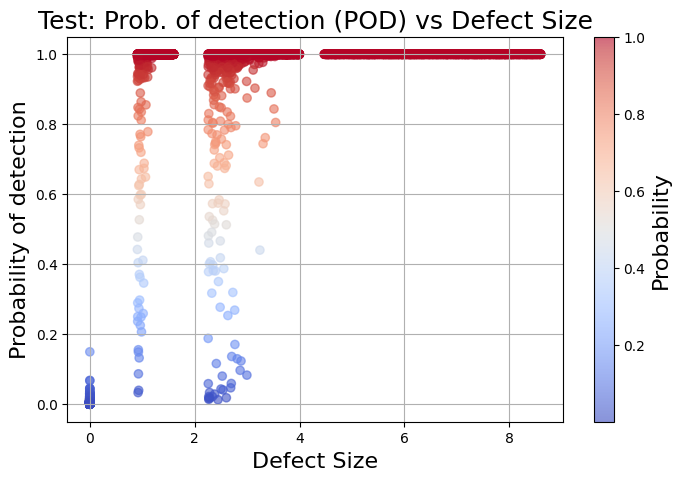

Epochs:  26%|██▌       | 130/500 [31:53<1:31:14, 14.80s/it]

Epoch 131


Epochs:  26%|██▌       | 131/500 [32:08<1:30:36, 14.73s/it]

Epoch 132


Epochs:  26%|██▋       | 132/500 [32:22<1:30:02, 14.68s/it]

Epoch 133


Epochs:  27%|██▋       | 133/500 [32:37<1:29:38, 14.65s/it]

Epoch 134


Epochs:  27%|██▋       | 134/500 [32:51<1:29:10, 14.62s/it]

Epoch 135


Epochs:  27%|██▋       | 135/500 [33:06<1:28:45, 14.59s/it]

Epoch 136


Epochs:  27%|██▋       | 136/500 [33:20<1:28:26, 14.58s/it]

Epoch 137


Epochs:  27%|██▋       | 137/500 [33:35<1:28:13, 14.58s/it]

Epoch 138


Epochs:  28%|██▊       | 138/500 [33:49<1:27:53, 14.57s/it]

Epoch 139


Epochs:  28%|██▊       | 139/500 [34:04<1:27:38, 14.57s/it]

Epoch 140


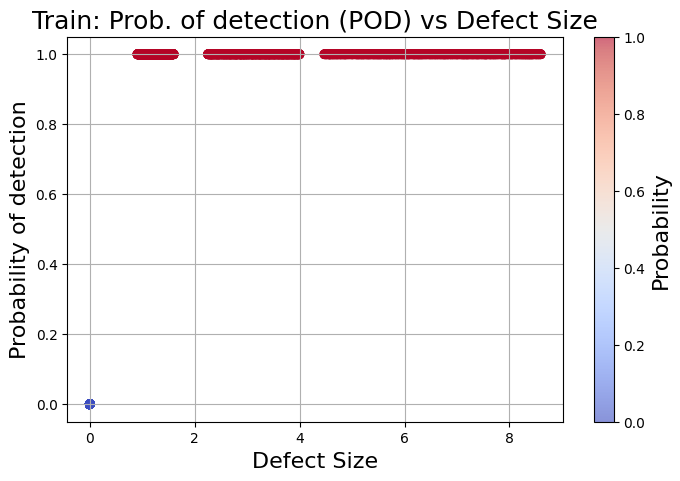

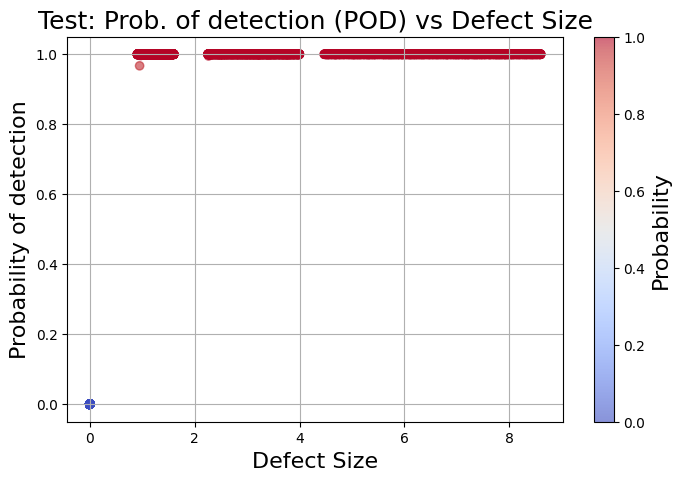

Epochs:  28%|██▊       | 140/500 [34:19<1:28:31, 14.75s/it]

Epoch 141


Epochs:  28%|██▊       | 141/500 [34:34<1:27:53, 14.69s/it]

Epoch 142


Epochs:  28%|██▊       | 142/500 [34:48<1:27:25, 14.65s/it]

Epoch 143


Epochs:  29%|██▊       | 143/500 [35:03<1:26:57, 14.61s/it]

Epoch 144


Epochs:  29%|██▉       | 144/500 [35:17<1:26:30, 14.58s/it]

Epoch 145


Epochs:  29%|██▉       | 145/500 [35:32<1:26:11, 14.57s/it]

Epoch 146


Epochs:  29%|██▉       | 146/500 [35:46<1:25:50, 14.55s/it]

Epoch 147


Epochs:  29%|██▉       | 147/500 [36:01<1:25:37, 14.55s/it]

Epoch 148


Epochs:  30%|██▉       | 148/500 [36:16<1:25:26, 14.56s/it]

Epoch 149


Epochs:  30%|██▉       | 149/500 [36:30<1:25:07, 14.55s/it]

Epoch 150


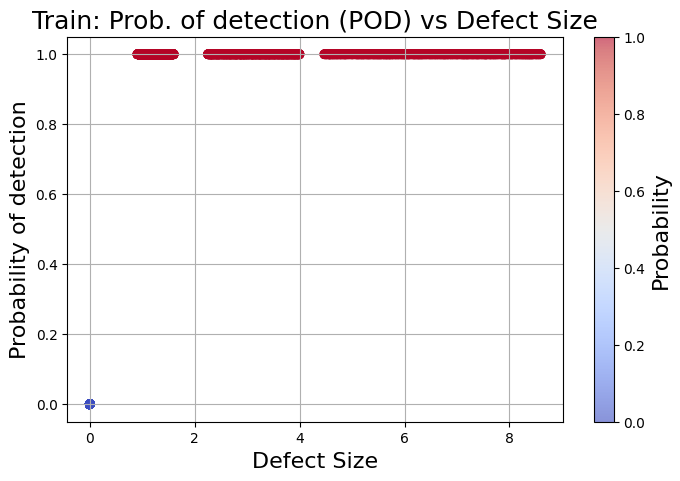

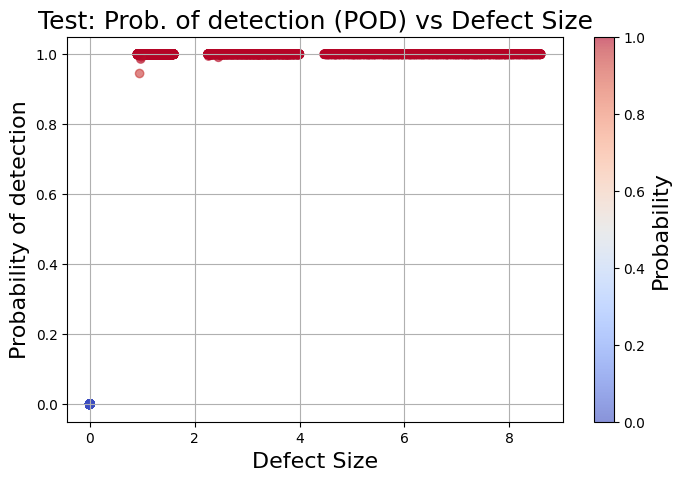

Epochs:  30%|███       | 150/500 [36:45<1:25:58, 14.74s/it]

Epoch 151


Epochs:  30%|███       | 151/500 [37:00<1:25:25, 14.69s/it]

Epoch 152


Epochs:  30%|███       | 152/500 [37:14<1:24:59, 14.65s/it]

Epoch 153


Epochs:  31%|███       | 153/500 [37:29<1:24:32, 14.62s/it]

Epoch 154


Epochs:  31%|███       | 154/500 [37:43<1:24:06, 14.58s/it]

Epoch 155


Epochs:  31%|███       | 155/500 [37:58<1:23:44, 14.56s/it]

Epoch 156


Epochs:  31%|███       | 156/500 [38:12<1:23:26, 14.55s/it]

Epoch 157


Epochs:  31%|███▏      | 157/500 [38:27<1:23:11, 14.55s/it]

Epoch 158


Epochs:  32%|███▏      | 158/500 [38:42<1:22:58, 14.56s/it]

Epoch 159


Epochs:  32%|███▏      | 159/500 [38:56<1:22:39, 14.54s/it]

Epoch 160


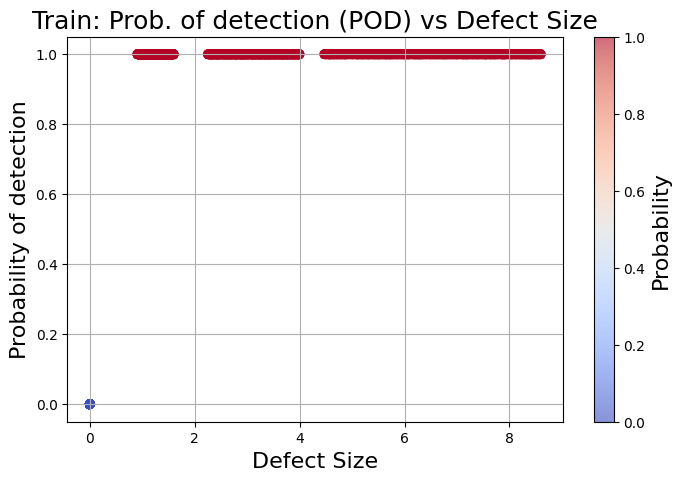

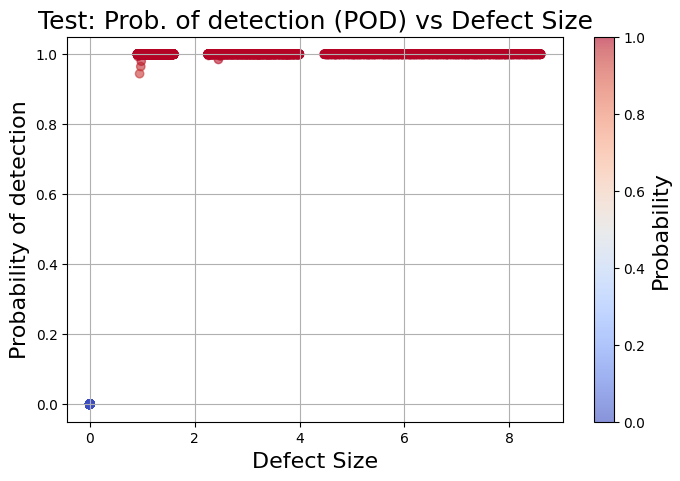

Epochs:  32%|███▏      | 160/500 [39:11<1:23:22, 14.71s/it]

Epoch 161


Epochs:  32%|███▏      | 161/500 [39:26<1:22:45, 14.65s/it]

Epoch 162


Epochs:  32%|███▏      | 162/500 [39:40<1:22:21, 14.62s/it]

Epoch 163


Epochs:  33%|███▎      | 163/500 [39:55<1:21:57, 14.59s/it]

Epoch 164


Epochs:  33%|███▎      | 164/500 [40:09<1:21:34, 14.57s/it]

Epoch 165


Epochs:  33%|███▎      | 165/500 [40:24<1:21:12, 14.54s/it]

Epoch 166


Epochs:  33%|███▎      | 166/500 [40:38<1:20:54, 14.53s/it]

Epoch 167


Epochs:  33%|███▎      | 167/500 [40:53<1:20:40, 14.54s/it]

Epoch 168


Epochs:  34%|███▎      | 168/500 [41:07<1:20:31, 14.55s/it]

Epoch 169


Epochs:  34%|███▍      | 169/500 [41:22<1:20:33, 14.60s/it]

Epoch 170


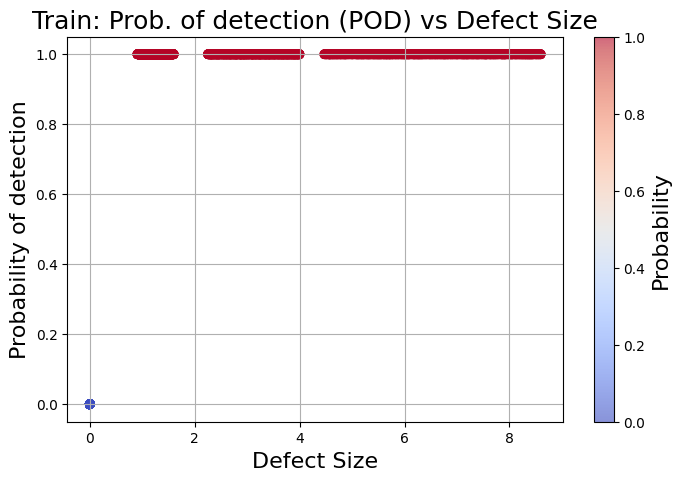

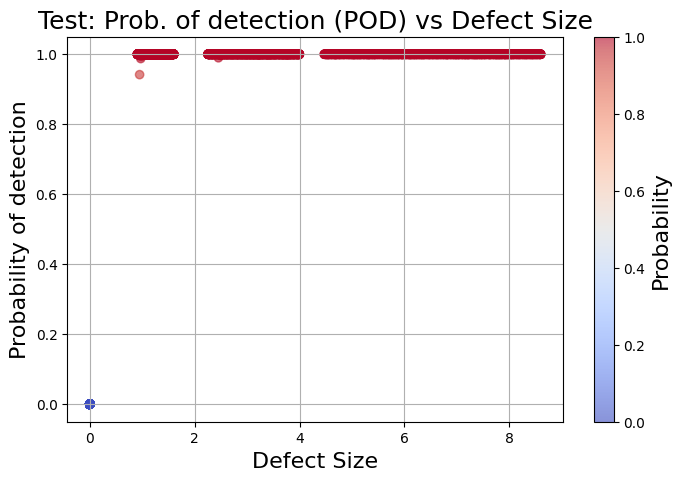

Epochs:  34%|███▍      | 170/500 [41:38<1:21:33, 14.83s/it]

Epoch 171


Epochs:  34%|███▍      | 171/500 [41:52<1:20:57, 14.76s/it]

Epoch 172


Epochs:  34%|███▍      | 172/500 [42:07<1:20:39, 14.75s/it]

Epoch 173


Epochs:  35%|███▍      | 173/500 [42:21<1:20:04, 14.69s/it]

Epoch 174


Epochs:  35%|███▍      | 174/500 [42:36<1:19:34, 14.65s/it]

Epoch 175


Epochs:  35%|███▌      | 175/500 [42:50<1:19:08, 14.61s/it]

Epoch 176


Epochs:  35%|███▌      | 176/500 [43:05<1:18:45, 14.59s/it]

Epoch 177


Epochs:  35%|███▌      | 177/500 [43:20<1:18:27, 14.57s/it]

Epoch 178


Epochs:  36%|███▌      | 178/500 [43:34<1:18:03, 14.54s/it]

Epoch 179


Epochs:  36%|███▌      | 179/500 [43:49<1:17:48, 14.54s/it]

Epoch 180


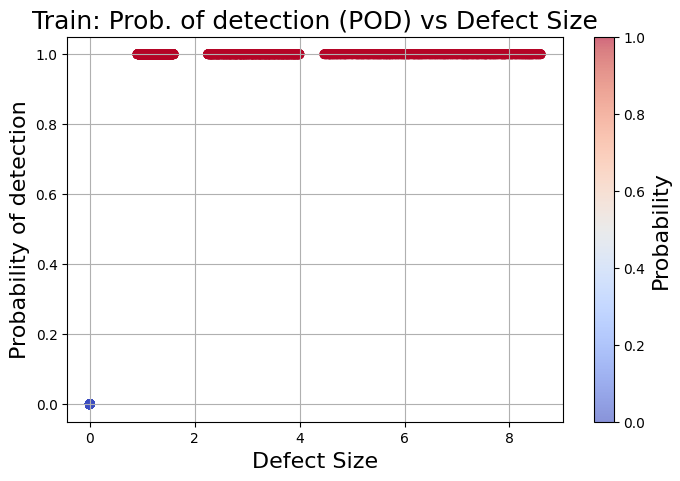

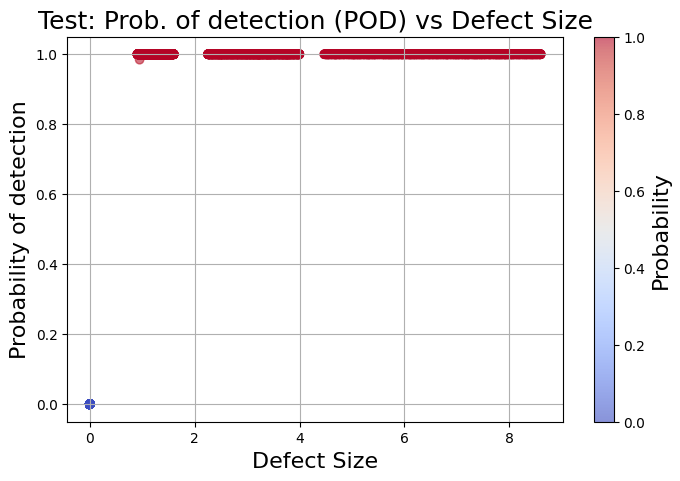

Epochs:  36%|███▌      | 180/500 [44:04<1:18:48, 14.78s/it]

Epoch 181


Epochs:  36%|███▌      | 181/500 [44:18<1:18:09, 14.70s/it]

Epoch 182


Epochs:  36%|███▋      | 182/500 [44:33<1:17:46, 14.67s/it]

Epoch 183


Epochs:  37%|███▋      | 183/500 [44:48<1:17:33, 14.68s/it]

Epoch 184


Epochs:  37%|███▋      | 184/500 [45:02<1:17:24, 14.70s/it]

Epoch 185


Epochs:  37%|███▋      | 185/500 [45:17<1:16:59, 14.67s/it]

Epoch 186


Epochs:  37%|███▋      | 186/500 [45:32<1:16:51, 14.69s/it]

Epoch 187


Epochs:  37%|███▋      | 187/500 [45:46<1:16:28, 14.66s/it]

Epoch 188


Epochs:  38%|███▊      | 188/500 [46:01<1:16:01, 14.62s/it]

Epoch 189


Epochs:  38%|███▊      | 189/500 [46:15<1:15:37, 14.59s/it]

Epoch 190


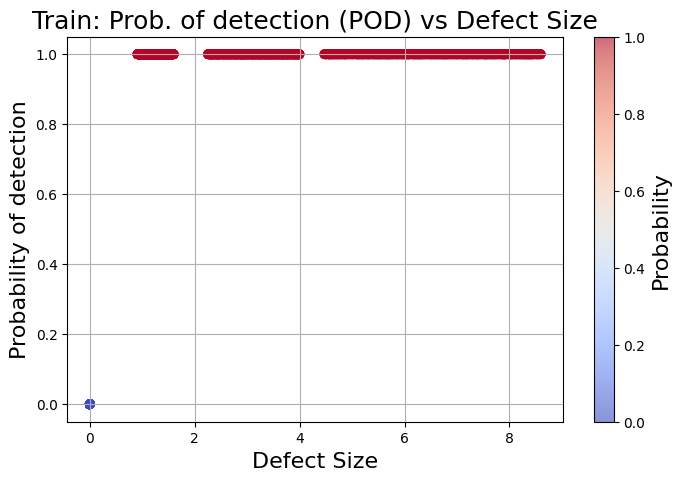

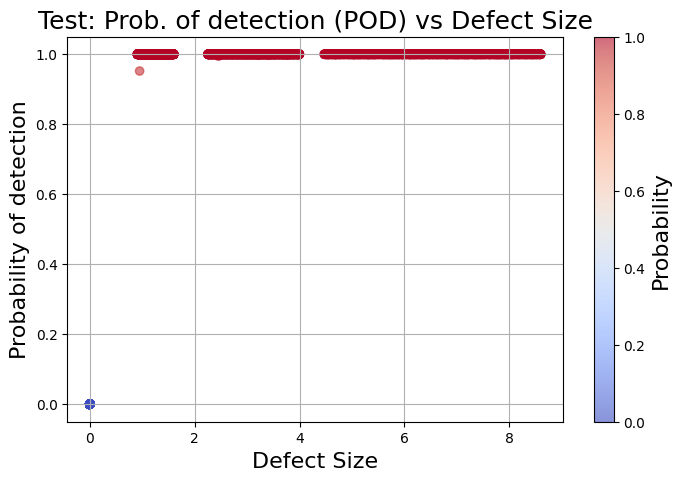

Epochs:  38%|███▊      | 190/500 [46:31<1:16:18, 14.77s/it]

Epoch 191


Epochs:  38%|███▊      | 191/500 [46:45<1:15:40, 14.69s/it]

Epoch 192


Epochs:  38%|███▊      | 192/500 [47:00<1:15:12, 14.65s/it]

Epoch 193


Epochs:  39%|███▊      | 193/500 [47:14<1:14:50, 14.63s/it]

Epoch 194


Epochs:  39%|███▉      | 194/500 [47:29<1:14:26, 14.60s/it]

Epoch 195


Epochs:  39%|███▉      | 195/500 [47:43<1:14:05, 14.58s/it]

Epoch 196


Epochs:  39%|███▉      | 196/500 [47:58<1:13:50, 14.57s/it]

Epoch 197


Epochs:  39%|███▉      | 197/500 [48:12<1:13:36, 14.58s/it]

Epoch 198


Epochs:  40%|███▉      | 198/500 [48:27<1:13:21, 14.58s/it]

Epoch 199


Epochs:  40%|███▉      | 199/500 [48:42<1:13:01, 14.56s/it]

Epoch 200


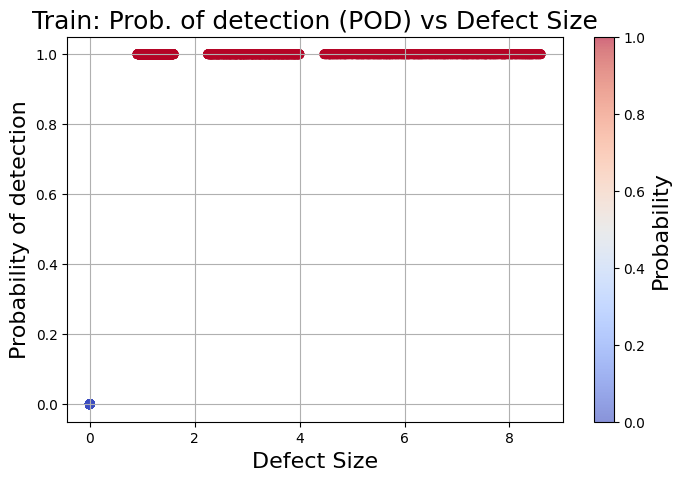

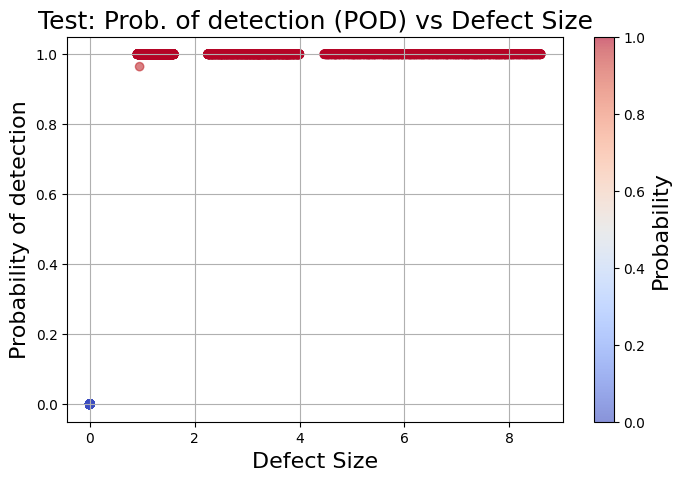

Epochs:  40%|████      | 200/500 [48:57<1:13:39, 14.73s/it]

Epoch 201


Epochs:  40%|████      | 201/500 [49:11<1:13:11, 14.69s/it]

Epoch 202


Epochs:  40%|████      | 202/500 [49:26<1:12:47, 14.66s/it]

Epoch 203


Epochs:  41%|████      | 203/500 [49:40<1:12:24, 14.63s/it]

Epoch 204


Epochs:  41%|████      | 204/500 [49:55<1:12:04, 14.61s/it]

Epoch 205


Epochs:  41%|████      | 205/500 [50:10<1:11:50, 14.61s/it]

Epoch 206


Epochs:  41%|████      | 206/500 [50:24<1:11:35, 14.61s/it]

Epoch 207


Epochs:  41%|████▏     | 207/500 [50:39<1:11:24, 14.62s/it]

Epoch 208


Epochs:  42%|████▏     | 208/500 [50:53<1:11:04, 14.61s/it]

Epoch 209


Epochs:  42%|████▏     | 209/500 [51:08<1:10:48, 14.60s/it]

Epoch 210


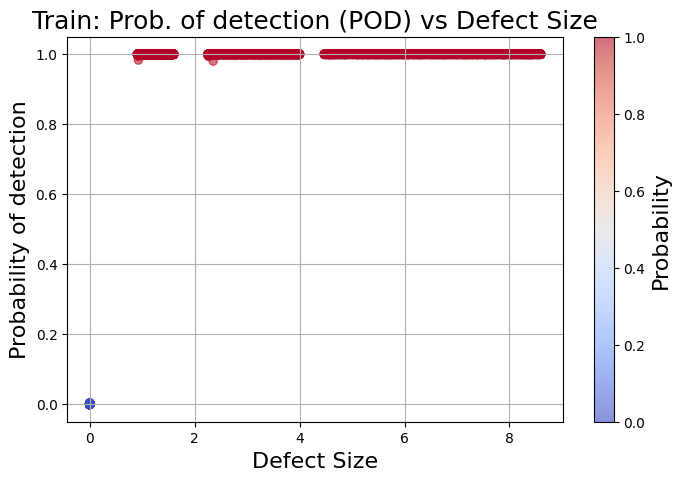

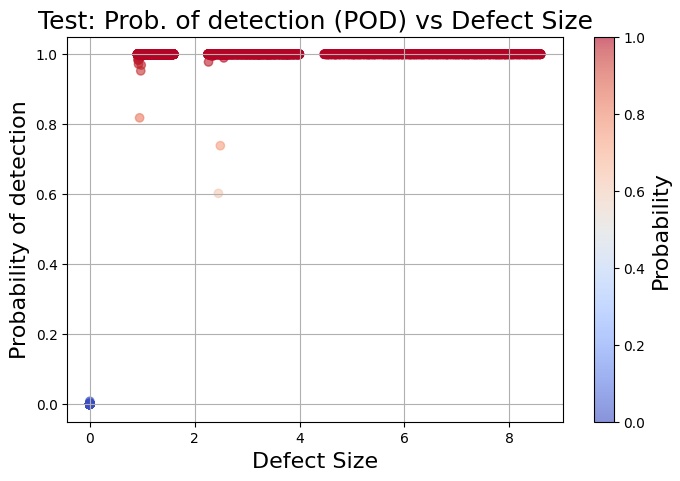

Epochs:  42%|████▏     | 210/500 [51:23<1:11:28, 14.79s/it]

Epoch 211


Epochs:  42%|████▏     | 211/500 [51:38<1:10:55, 14.73s/it]

Epoch 212


Epochs:  42%|████▏     | 212/500 [51:52<1:10:29, 14.69s/it]

Epoch 213


Epochs:  43%|████▎     | 213/500 [52:07<1:10:09, 14.67s/it]

Epoch 214


Epochs:  43%|████▎     | 214/500 [52:22<1:09:46, 14.64s/it]

Epoch 215


Epochs:  43%|████▎     | 215/500 [52:36<1:09:27, 14.62s/it]

Epoch 216


Epochs:  43%|████▎     | 216/500 [52:51<1:09:12, 14.62s/it]

Epoch 217


Epochs:  43%|████▎     | 217/500 [53:05<1:08:57, 14.62s/it]

Epoch 218


Epochs:  44%|████▎     | 218/500 [53:20<1:08:41, 14.62s/it]

Epoch 219


Epochs:  44%|████▍     | 219/500 [53:35<1:08:22, 14.60s/it]

Epoch 220


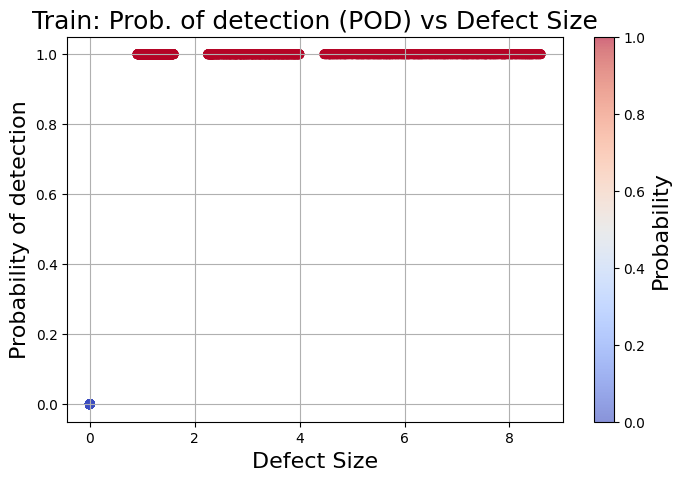

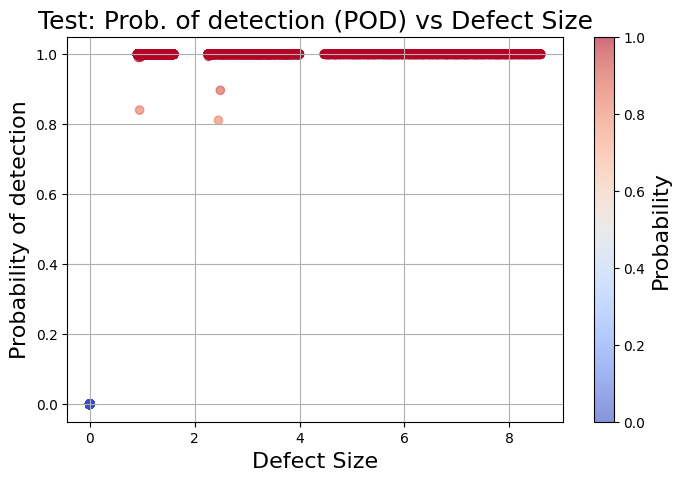

Epochs:  44%|████▍     | 220/500 [53:50<1:09:01, 14.79s/it]

Epoch 221


Epochs:  44%|████▍     | 221/500 [54:04<1:08:30, 14.73s/it]

Epoch 222


Epochs:  44%|████▍     | 222/500 [54:19<1:08:06, 14.70s/it]

Epoch 223


Epochs:  45%|████▍     | 223/500 [54:34<1:07:40, 14.66s/it]

Epoch 224


Epochs:  45%|████▍     | 224/500 [54:48<1:07:15, 14.62s/it]

Epoch 225


Epochs:  45%|████▌     | 225/500 [55:03<1:06:56, 14.61s/it]

Epoch 226


Epochs:  45%|████▌     | 226/500 [55:17<1:06:53, 14.65s/it]

Epoch 227


Epochs:  45%|████▌     | 227/500 [55:32<1:06:35, 14.64s/it]

Epoch 228


Epochs:  46%|████▌     | 228/500 [55:47<1:06:12, 14.61s/it]

Epoch 229


Epochs:  46%|████▌     | 229/500 [56:01<1:05:51, 14.58s/it]

Epoch 230


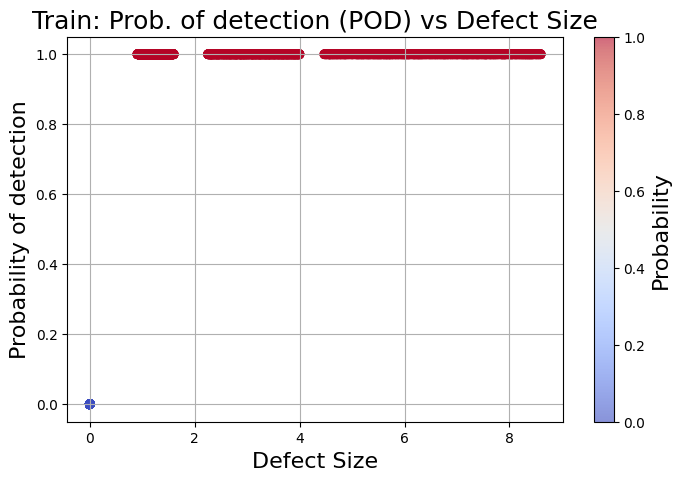

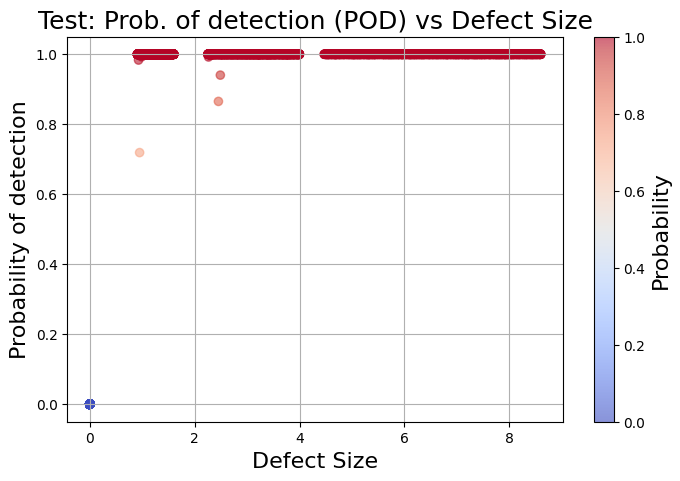

Epochs:  46%|████▌     | 230/500 [56:17<1:06:44, 14.83s/it]

Epoch 231


Epochs:  46%|████▌     | 231/500 [56:31<1:06:08, 14.75s/it]

Epoch 232


Epochs:  46%|████▋     | 232/500 [56:46<1:05:40, 14.70s/it]

Epoch 233


Epochs:  47%|████▋     | 233/500 [57:00<1:05:16, 14.67s/it]

Epoch 234


Epochs:  47%|████▋     | 234/500 [57:15<1:04:49, 14.62s/it]

Epoch 235


Epochs:  47%|████▋     | 235/500 [57:29<1:04:27, 14.59s/it]

Epoch 236


Epochs:  47%|████▋     | 236/500 [57:44<1:04:06, 14.57s/it]

Epoch 237


Epochs:  47%|████▋     | 237/500 [57:58<1:03:54, 14.58s/it]

Epoch 238


Epochs:  48%|████▊     | 238/500 [58:13<1:03:33, 14.55s/it]

Epoch 239


Epochs:  48%|████▊     | 239/500 [58:27<1:03:14, 14.54s/it]

Epoch 240


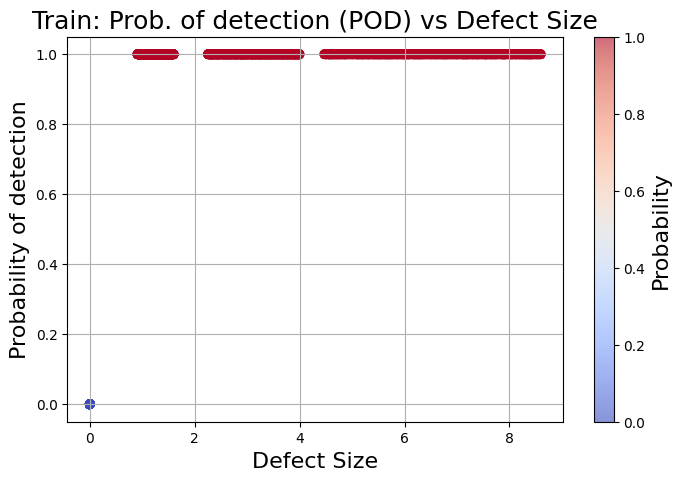

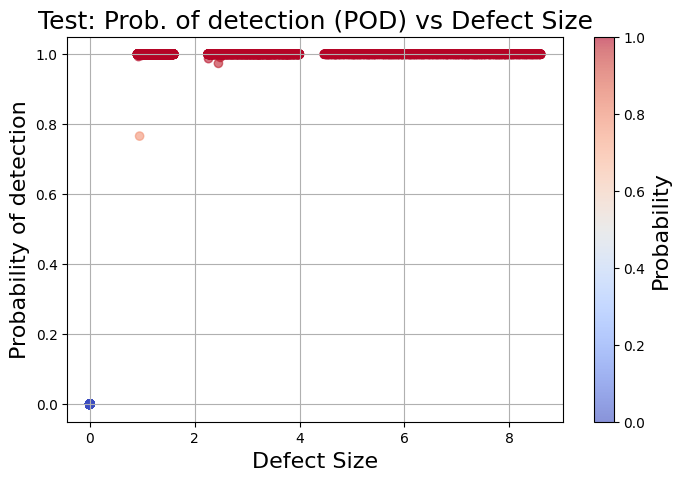

Epochs:  48%|████▊     | 240/500 [58:43<1:03:46, 14.72s/it]

Epoch 241


Epochs:  48%|████▊     | 241/500 [58:57<1:03:16, 14.66s/it]

Epoch 242


Epochs:  48%|████▊     | 242/500 [59:12<1:02:54, 14.63s/it]

Epoch 243


Epochs:  49%|████▊     | 243/500 [59:26<1:02:27, 14.58s/it]

Epoch 244


Epochs:  49%|████▉     | 244/500 [59:41<1:02:07, 14.56s/it]

Epoch 245


Epochs:  49%|████▉     | 245/500 [59:55<1:01:48, 14.54s/it]

Epoch 246


Epochs:  49%|████▉     | 246/500 [1:00:10<1:01:32, 14.54s/it]

Epoch 247


Epochs:  49%|████▉     | 247/500 [1:00:24<1:01:18, 14.54s/it]

Epoch 248


Epochs:  50%|████▉     | 248/500 [1:00:39<1:01:00, 14.52s/it]

Epoch 249


Epochs:  50%|████▉     | 249/500 [1:00:53<1:00:43, 14.52s/it]

Epoch 250


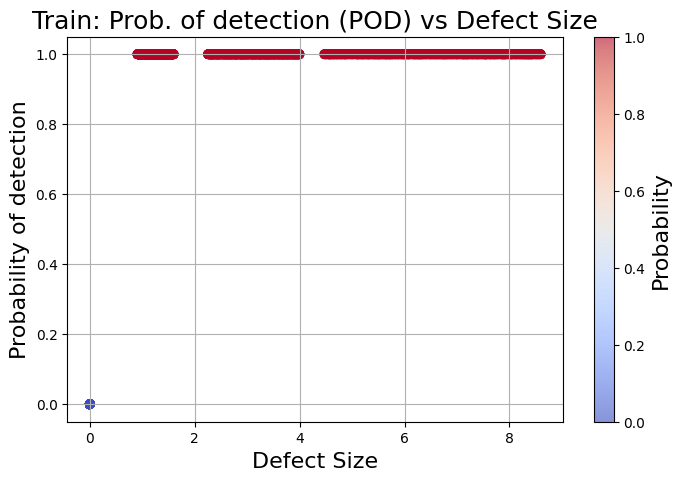

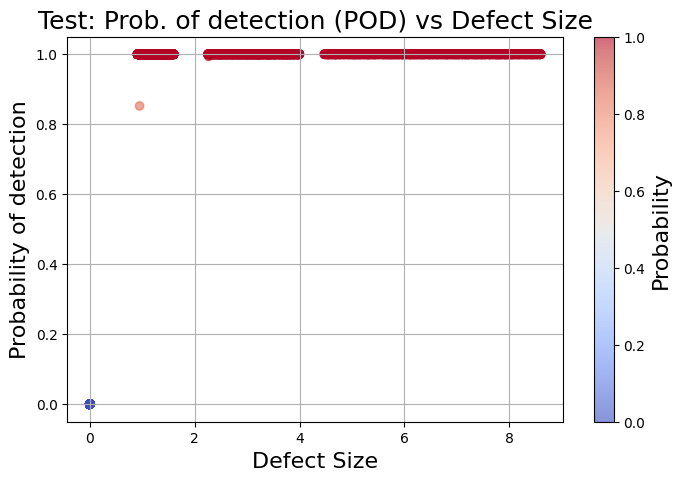

Epochs:  50%|█████     | 250/500 [1:01:08<1:01:17, 14.71s/it]

Epoch 251


Epochs:  50%|█████     | 251/500 [1:01:23<1:00:49, 14.66s/it]

Epoch 252


Epochs:  50%|█████     | 252/500 [1:01:37<1:00:28, 14.63s/it]

Epoch 253


Epochs:  51%|█████     | 253/500 [1:01:52<1:00:07, 14.61s/it]

Epoch 254


Epochs:  51%|█████     | 254/500 [1:02:07<59:46, 14.58s/it]  

Epoch 255


Epochs:  51%|█████     | 255/500 [1:02:21<59:27, 14.56s/it]

Epoch 256


Epochs:  51%|█████     | 256/500 [1:02:36<59:10, 14.55s/it]

Epoch 257


Epochs:  51%|█████▏    | 257/500 [1:02:50<58:56, 14.55s/it]

Epoch 258


Epochs:  52%|█████▏    | 258/500 [1:03:05<58:40, 14.55s/it]

Epoch 259


Epochs:  52%|█████▏    | 259/500 [1:03:19<58:26, 14.55s/it]

Epoch 260


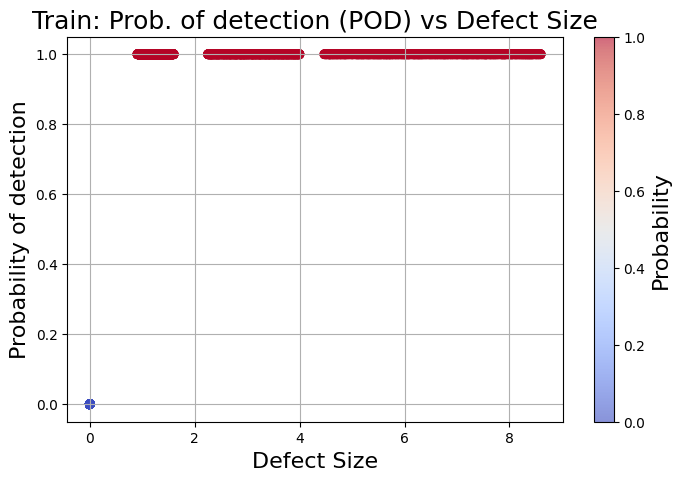

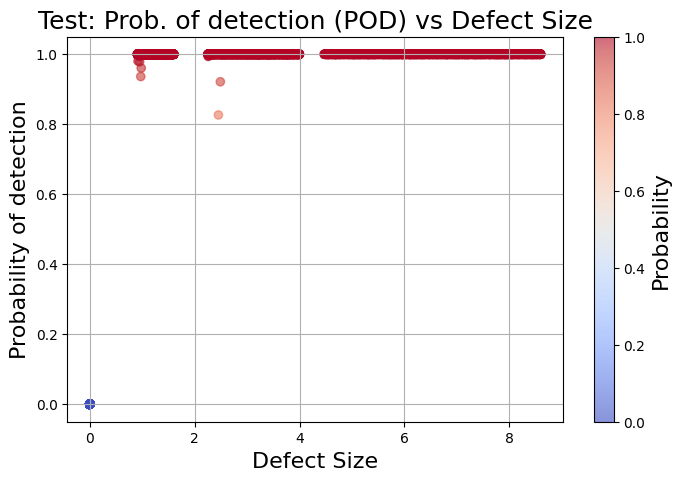

Epochs:  52%|█████▏    | 260/500 [1:03:35<59:08, 14.79s/it]

Epoch 261


Epochs:  52%|█████▏    | 261/500 [1:03:49<58:49, 14.77s/it]

Epoch 262


Epochs:  52%|█████▏    | 262/500 [1:04:04<58:28, 14.74s/it]

Epoch 263


Epochs:  53%|█████▎    | 263/500 [1:04:19<58:09, 14.72s/it]

Epoch 264


Epochs:  53%|█████▎    | 264/500 [1:04:33<57:47, 14.69s/it]

Epoch 265


Epochs:  53%|█████▎    | 265/500 [1:04:48<57:20, 14.64s/it]

Epoch 266


Epochs:  53%|█████▎    | 266/500 [1:05:02<57:01, 14.62s/it]

Epoch 267


Epochs:  53%|█████▎    | 267/500 [1:05:17<56:42, 14.60s/it]

Epoch 268


Epochs:  54%|█████▎    | 268/500 [1:05:31<56:21, 14.58s/it]

Epoch 269


Epochs:  54%|█████▍    | 269/500 [1:05:46<56:02, 14.56s/it]

Epoch 270


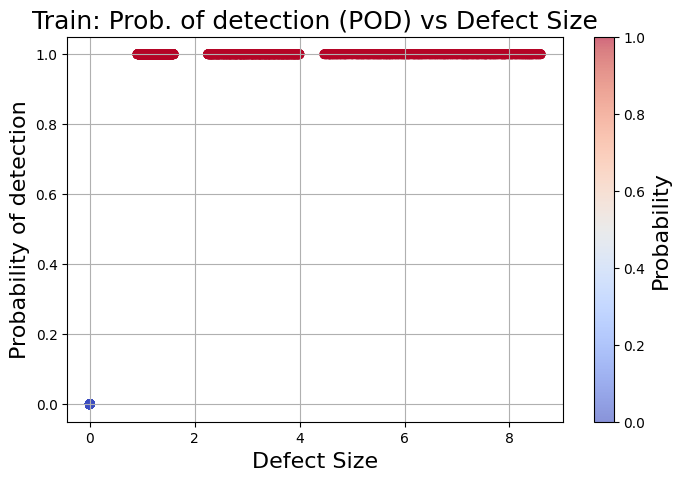

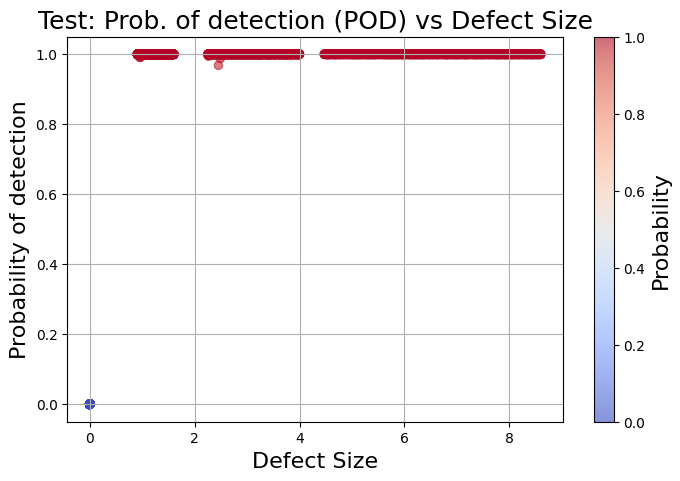

Epochs:  54%|█████▍    | 270/500 [1:06:01<56:31, 14.74s/it]

Epoch 271


Epochs:  54%|█████▍    | 271/500 [1:06:16<56:04, 14.69s/it]

Epoch 272


Epochs:  54%|█████▍    | 272/500 [1:06:30<55:41, 14.66s/it]

Epoch 273


Epochs:  55%|█████▍    | 273/500 [1:06:45<55:22, 14.64s/it]

Epoch 274


Epochs:  55%|█████▍    | 274/500 [1:06:59<55:01, 14.61s/it]

Epoch 275


Epochs:  55%|█████▌    | 275/500 [1:07:14<54:41, 14.58s/it]

Epoch 276


Epochs:  55%|█████▌    | 276/500 [1:07:29<54:27, 14.59s/it]

Epoch 277


Epochs:  55%|█████▌    | 277/500 [1:07:43<54:13, 14.59s/it]

Epoch 278


Epochs:  56%|█████▌    | 278/500 [1:07:58<53:57, 14.58s/it]

Epoch 279


Epochs:  56%|█████▌    | 279/500 [1:08:12<53:41, 14.58s/it]

Epoch 280


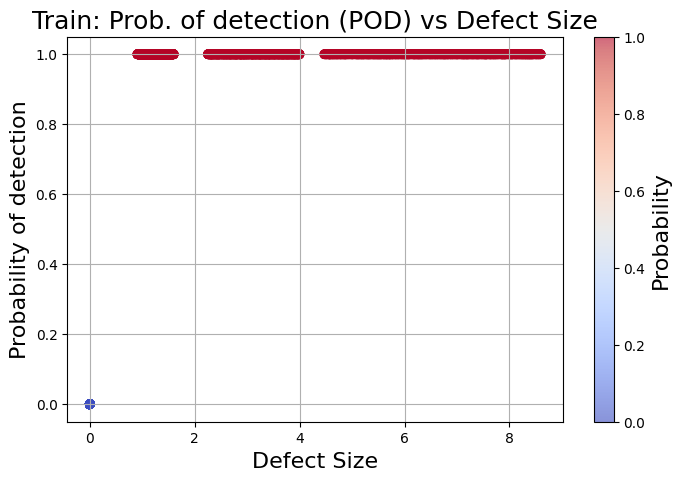

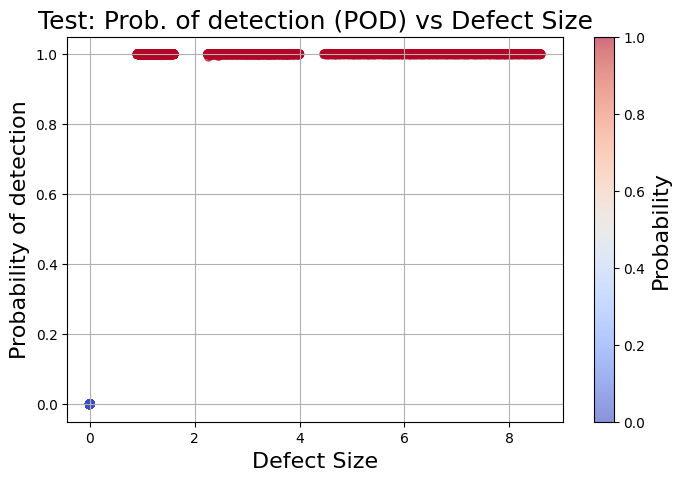

Epochs:  56%|█████▌    | 280/500 [1:08:27<54:09, 14.77s/it]

Epoch 281


Epochs:  56%|█████▌    | 281/500 [1:08:42<53:41, 14.71s/it]

Epoch 282


Epochs:  56%|█████▋    | 282/500 [1:08:57<53:19, 14.68s/it]

Epoch 283


Epochs:  57%|█████▋    | 283/500 [1:09:11<53:07, 14.69s/it]

Epoch 284


Epochs:  57%|█████▋    | 284/500 [1:09:26<52:48, 14.67s/it]

Epoch 285


Epochs:  57%|█████▋    | 285/500 [1:09:41<52:28, 14.64s/it]

Epoch 286


Epochs:  57%|█████▋    | 286/500 [1:09:55<52:22, 14.68s/it]

Epoch 287


Epochs:  57%|█████▋    | 287/500 [1:10:10<52:14, 14.72s/it]

Epoch 288


Epochs:  58%|█████▊    | 288/500 [1:10:25<51:58, 14.71s/it]

Epoch 289


Epochs:  58%|█████▊    | 289/500 [1:10:40<51:43, 14.71s/it]

Epoch 290


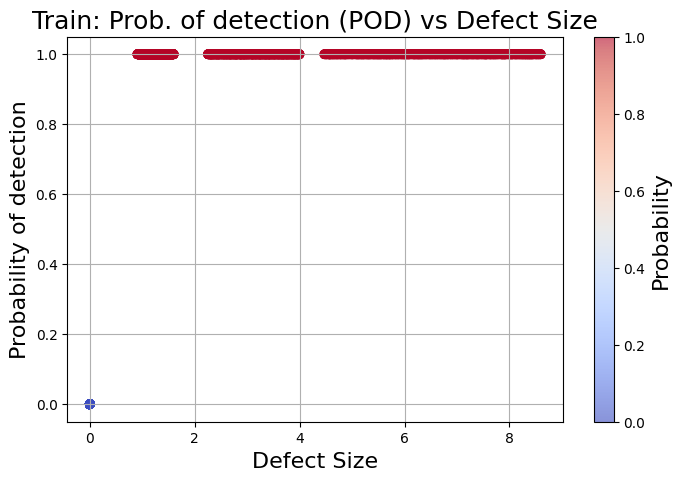

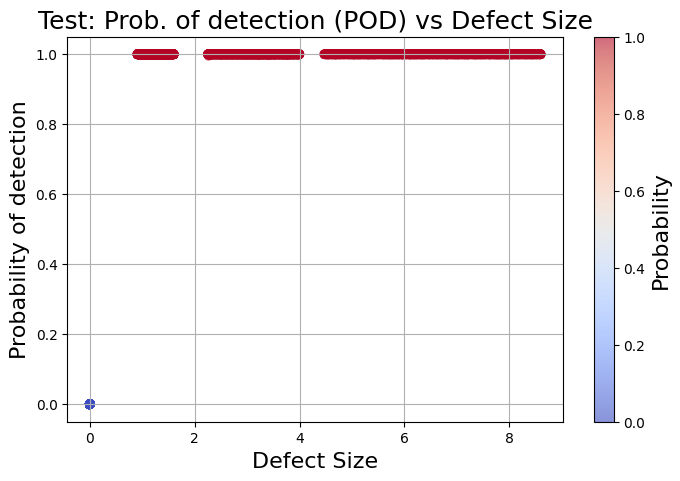

Epochs:  58%|█████▊    | 290/500 [1:10:55<52:08, 14.90s/it]

Epoch 291


Epochs:  58%|█████▊    | 291/500 [1:11:10<51:36, 14.81s/it]

Epoch 292


Epochs:  58%|█████▊    | 292/500 [1:11:24<51:06, 14.74s/it]

Epoch 293


Epochs:  59%|█████▊    | 293/500 [1:11:39<50:40, 14.69s/it]

Epoch 294


Epochs:  59%|█████▉    | 294/500 [1:11:53<50:17, 14.65s/it]

Epoch 295


Epochs:  59%|█████▉    | 295/500 [1:12:08<49:58, 14.63s/it]

Epoch 296


Epochs:  59%|█████▉    | 296/500 [1:12:22<49:43, 14.62s/it]

Epoch 297


Epochs:  59%|█████▉    | 297/500 [1:12:37<49:25, 14.61s/it]

Epoch 298


Epochs:  60%|█████▉    | 298/500 [1:12:52<49:08, 14.60s/it]

Epoch 299


Epochs:  60%|█████▉    | 299/500 [1:13:06<48:55, 14.60s/it]

Epoch 300


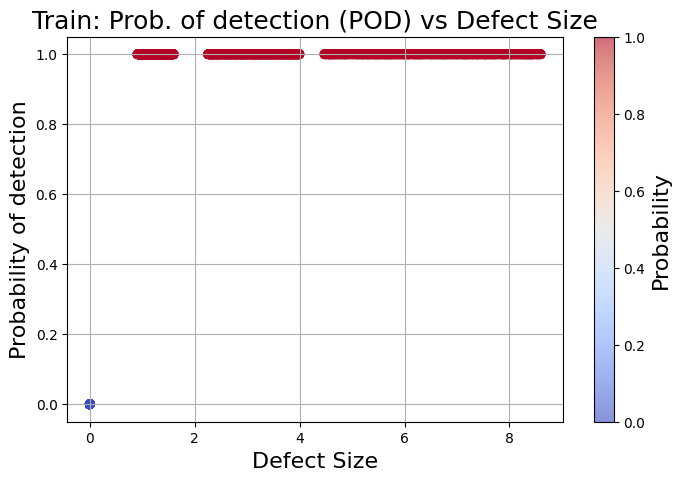

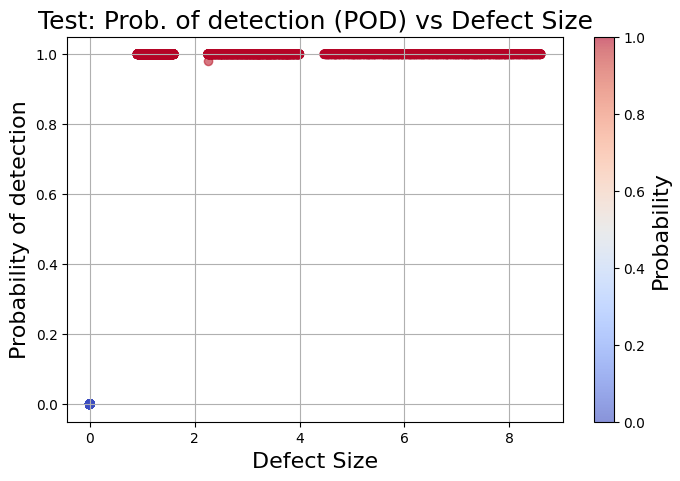

Epochs:  60%|██████    | 300/500 [1:13:21<49:17, 14.79s/it]

Epoch 301


Epochs:  60%|██████    | 301/500 [1:13:36<48:52, 14.73s/it]

Epoch 302


Epochs:  60%|██████    | 302/500 [1:13:51<48:27, 14.69s/it]

Epoch 303


Epochs:  61%|██████    | 303/500 [1:14:05<48:06, 14.65s/it]

Epoch 304


Epochs:  61%|██████    | 304/500 [1:14:20<47:47, 14.63s/it]

Epoch 305


Epochs:  61%|██████    | 305/500 [1:14:34<47:30, 14.62s/it]

Epoch 306


Epochs:  61%|██████    | 306/500 [1:14:49<47:14, 14.61s/it]

Epoch 307


Epochs:  61%|██████▏   | 307/500 [1:15:03<46:57, 14.60s/it]

Epoch 308


Epochs:  62%|██████▏   | 308/500 [1:15:18<46:40, 14.59s/it]

Epoch 309


Epochs:  62%|██████▏   | 309/500 [1:15:33<46:22, 14.57s/it]

Epoch 310


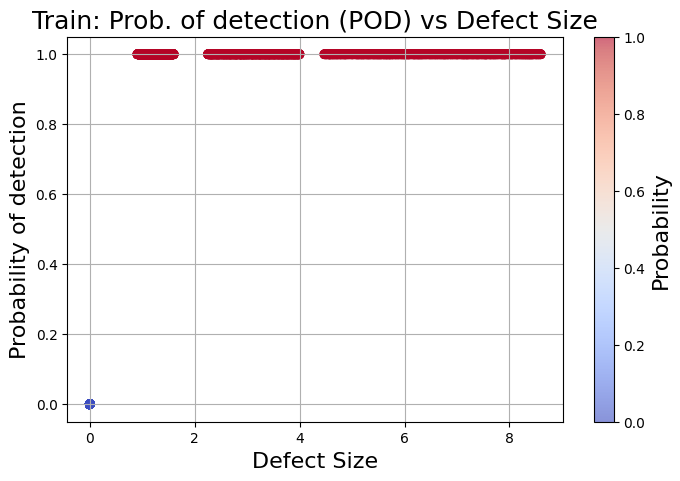

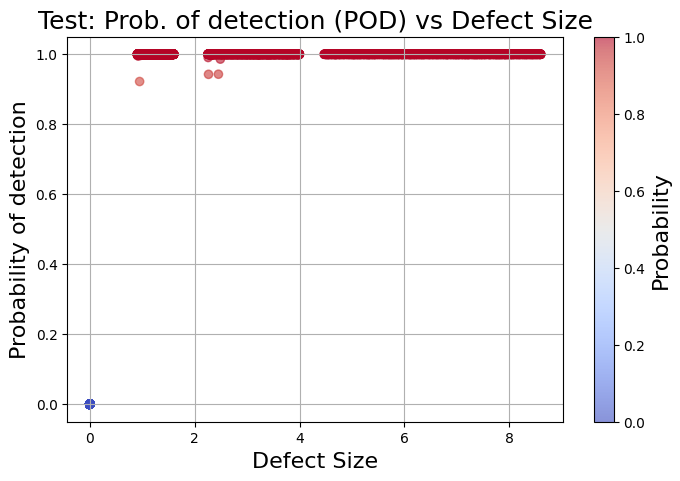

Epochs:  62%|██████▏   | 310/500 [1:15:48<46:46, 14.77s/it]

Epoch 311


Epochs:  62%|██████▏   | 311/500 [1:16:02<46:19, 14.71s/it]

Epoch 312


Epochs:  62%|██████▏   | 312/500 [1:16:17<45:56, 14.66s/it]

Epoch 313


Epochs:  63%|██████▎   | 313/500 [1:16:31<45:35, 14.63s/it]

Epoch 314


Epochs:  63%|██████▎   | 314/500 [1:16:46<45:17, 14.61s/it]

Epoch 315


Epochs:  63%|██████▎   | 315/500 [1:17:01<45:02, 14.61s/it]

Epoch 316


Epochs:  63%|██████▎   | 316/500 [1:17:15<44:44, 14.59s/it]

Epoch 317


Epochs:  63%|██████▎   | 317/500 [1:17:30<44:28, 14.58s/it]

Epoch 318


Epochs:  64%|██████▎   | 318/500 [1:17:44<44:11, 14.57s/it]

Epoch 319


Epochs:  64%|██████▍   | 319/500 [1:17:59<43:57, 14.57s/it]

Epoch 320


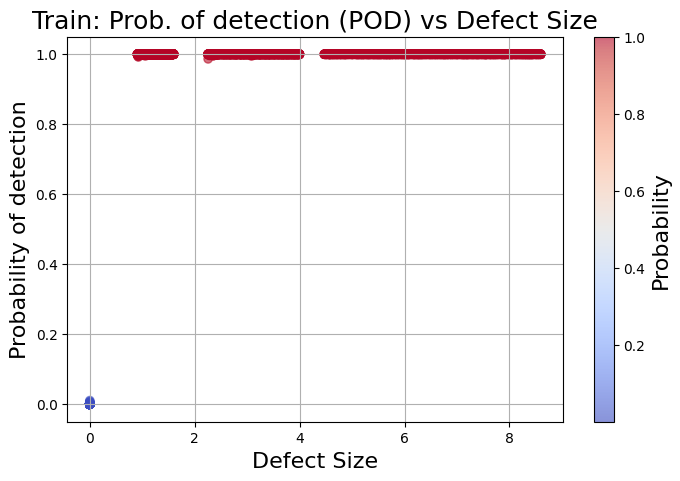

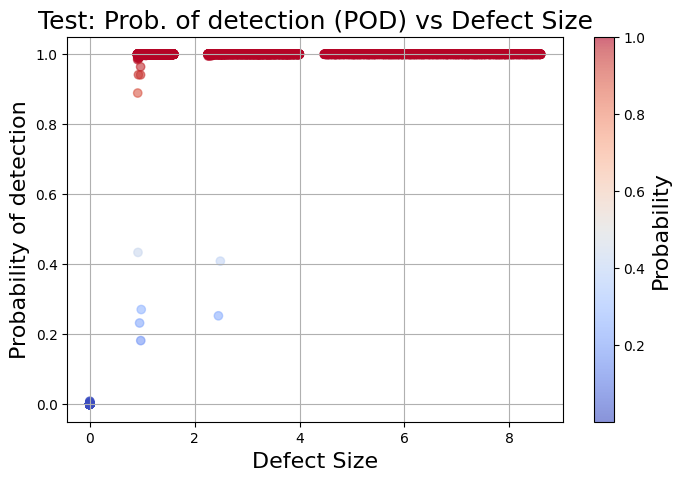

Epochs:  64%|██████▍   | 320/500 [1:18:14<44:21, 14.78s/it]

Epoch 321


Epochs:  64%|██████▍   | 321/500 [1:18:29<43:52, 14.71s/it]

Epoch 322


Epochs:  64%|██████▍   | 322/500 [1:18:43<43:28, 14.65s/it]

Epoch 323


Epochs:  65%|██████▍   | 323/500 [1:18:58<43:07, 14.62s/it]

Epoch 324


Epochs:  65%|██████▍   | 324/500 [1:19:12<42:49, 14.60s/it]

Epoch 325


Epochs:  65%|██████▌   | 325/500 [1:19:27<42:35, 14.60s/it]

Epoch 326


Epochs:  65%|██████▌   | 326/500 [1:19:41<42:17, 14.58s/it]

Epoch 327


Epochs:  65%|██████▌   | 327/500 [1:19:56<42:00, 14.57s/it]

Epoch 328


Epochs:  66%|██████▌   | 328/500 [1:20:11<41:45, 14.56s/it]

Epoch 329


Epochs:  66%|██████▌   | 329/500 [1:20:25<41:29, 14.56s/it]

Epoch 330


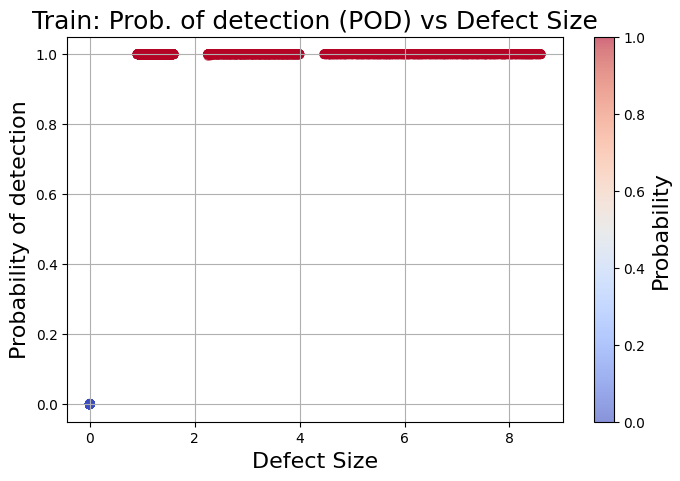

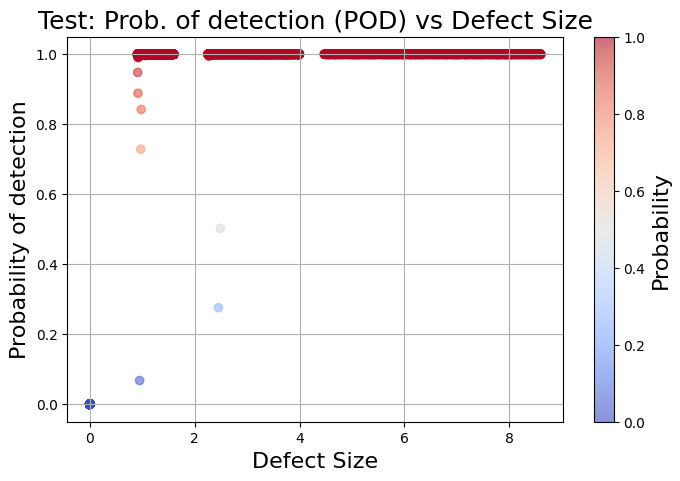

Epochs:  66%|██████▌   | 330/500 [1:20:40<41:48, 14.75s/it]

Epoch 331


Epochs:  66%|██████▌   | 331/500 [1:20:55<41:20, 14.68s/it]

Epoch 332


Epochs:  66%|██████▋   | 332/500 [1:21:09<40:58, 14.64s/it]

Epoch 333


Epochs:  67%|██████▋   | 333/500 [1:21:24<40:38, 14.60s/it]

Epoch 334


Epochs:  67%|██████▋   | 334/500 [1:21:38<40:20, 14.58s/it]

Epoch 335


Epochs:  67%|██████▋   | 335/500 [1:21:53<40:04, 14.57s/it]

Epoch 336


Epochs:  67%|██████▋   | 336/500 [1:22:07<39:48, 14.56s/it]

Epoch 337


Epochs:  67%|██████▋   | 337/500 [1:22:22<39:31, 14.55s/it]

Epoch 338


Epochs:  68%|██████▊   | 338/500 [1:22:36<39:13, 14.53s/it]

Epoch 339


Epochs:  68%|██████▊   | 339/500 [1:22:51<39:00, 14.54s/it]

Epoch 340


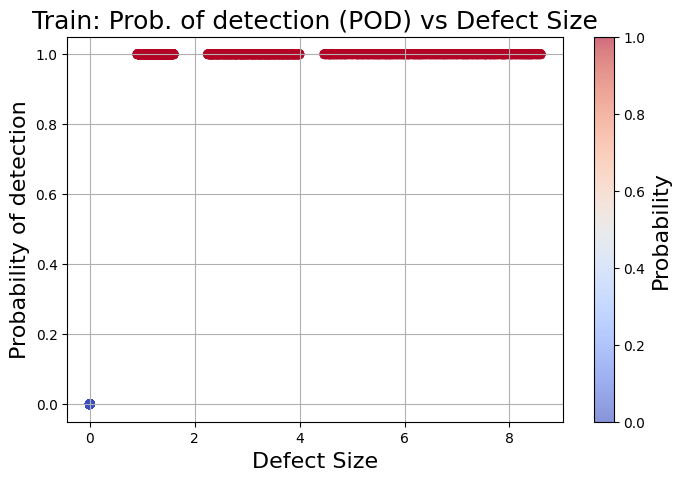

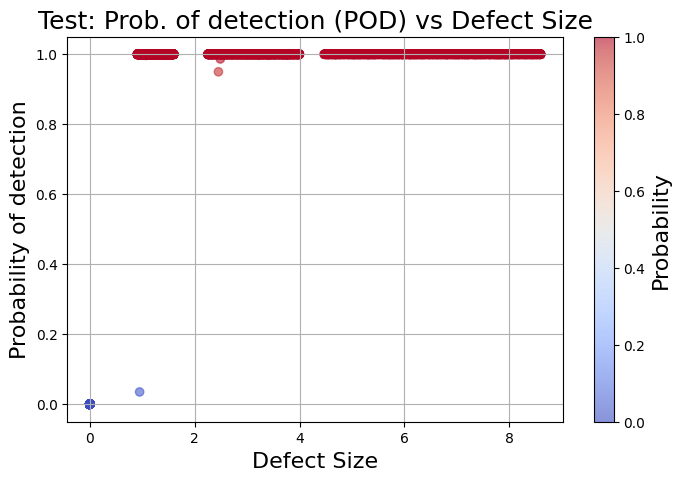

Epochs:  68%|██████▊   | 340/500 [1:23:06<39:17, 14.73s/it]

Epoch 341


Epochs:  68%|██████▊   | 341/500 [1:23:21<38:53, 14.68s/it]

Epoch 342


Epochs:  68%|██████▊   | 342/500 [1:23:35<38:35, 14.65s/it]

Epoch 343


Epochs:  69%|██████▊   | 343/500 [1:23:50<38:14, 14.62s/it]

Epoch 344


Epochs:  69%|██████▉   | 344/500 [1:24:04<37:57, 14.60s/it]

Epoch 345


Epochs:  69%|██████▉   | 345/500 [1:24:19<37:40, 14.59s/it]

Epoch 346


Epochs:  69%|██████▉   | 346/500 [1:24:33<37:20, 14.55s/it]

Epoch 347


Epochs:  69%|██████▉   | 347/500 [1:24:48<37:06, 14.55s/it]

Epoch 348


Epochs:  70%|██████▉   | 348/500 [1:25:03<36:50, 14.54s/it]

Epoch 349


Epochs:  70%|██████▉   | 349/500 [1:25:17<36:35, 14.54s/it]

Epoch 350


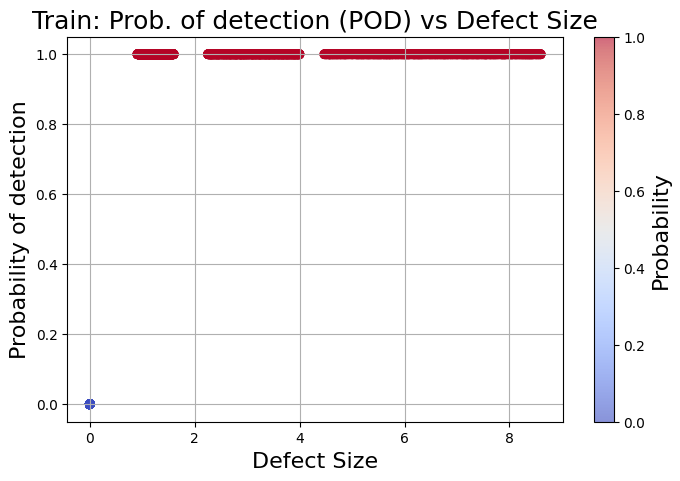

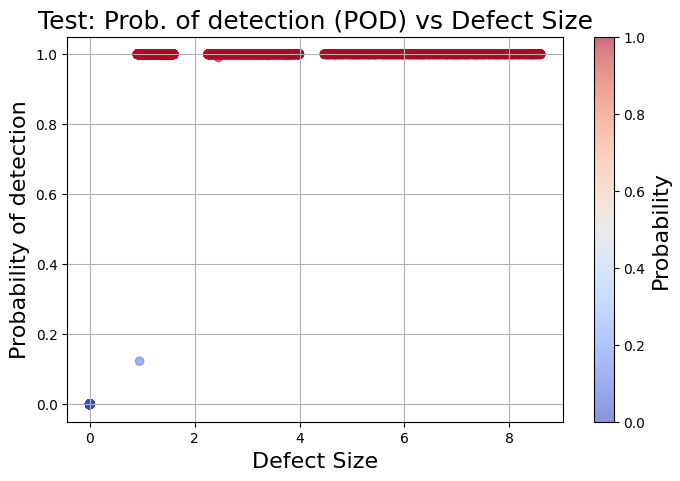

Epochs:  70%|███████   | 350/500 [1:25:33<37:01, 14.81s/it]

Epoch 351


Epochs:  70%|███████   | 351/500 [1:25:47<36:33, 14.72s/it]

Epoch 352


Epochs:  70%|███████   | 352/500 [1:26:02<36:10, 14.66s/it]

Epoch 353


Epochs:  71%|███████   | 353/500 [1:26:16<35:50, 14.63s/it]

Epoch 354


Epochs:  71%|███████   | 354/500 [1:26:31<35:35, 14.63s/it]

Epoch 355


Epochs:  71%|███████   | 355/500 [1:26:45<35:19, 14.62s/it]

Epoch 356


Epochs:  71%|███████   | 356/500 [1:27:00<35:07, 14.64s/it]

Epoch 357


Epochs:  71%|███████▏  | 357/500 [1:27:15<34:47, 14.60s/it]

Epoch 358


Epochs:  72%|███████▏  | 358/500 [1:27:29<34:31, 14.59s/it]

Epoch 359


Epochs:  72%|███████▏  | 359/500 [1:27:44<34:15, 14.58s/it]

Epoch 360


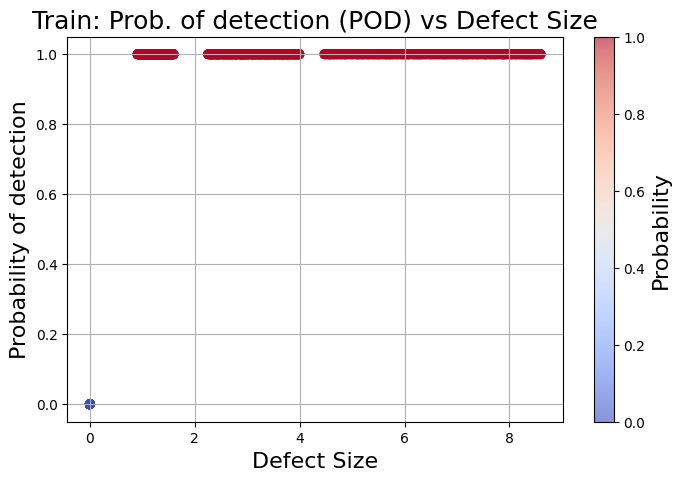

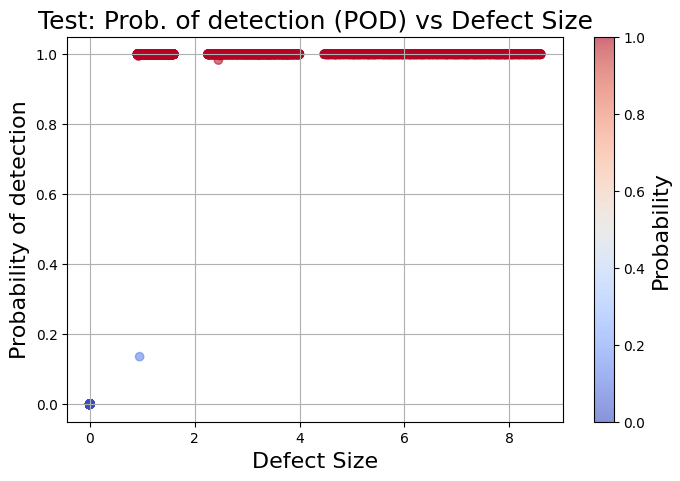

Epochs:  72%|███████▏  | 360/500 [1:27:59<34:29, 14.78s/it]

Epoch 361


Epochs:  72%|███████▏  | 361/500 [1:28:13<34:04, 14.71s/it]

Epoch 362


Epochs:  72%|███████▏  | 362/500 [1:28:28<33:42, 14.66s/it]

Epoch 363


Epochs:  73%|███████▎  | 363/500 [1:28:43<33:23, 14.63s/it]

Epoch 364


Epochs:  73%|███████▎  | 364/500 [1:28:57<33:07, 14.61s/it]

Epoch 365


Epochs:  73%|███████▎  | 365/500 [1:29:12<32:48, 14.58s/it]

Epoch 366


Epochs:  73%|███████▎  | 366/500 [1:29:26<32:31, 14.56s/it]

Epoch 367


Epochs:  73%|███████▎  | 367/500 [1:29:41<32:16, 14.56s/it]

Epoch 368


Epochs:  74%|███████▎  | 368/500 [1:29:55<32:01, 14.56s/it]

Epoch 369


Epochs:  74%|███████▍  | 369/500 [1:30:10<31:48, 14.57s/it]

Epoch 370


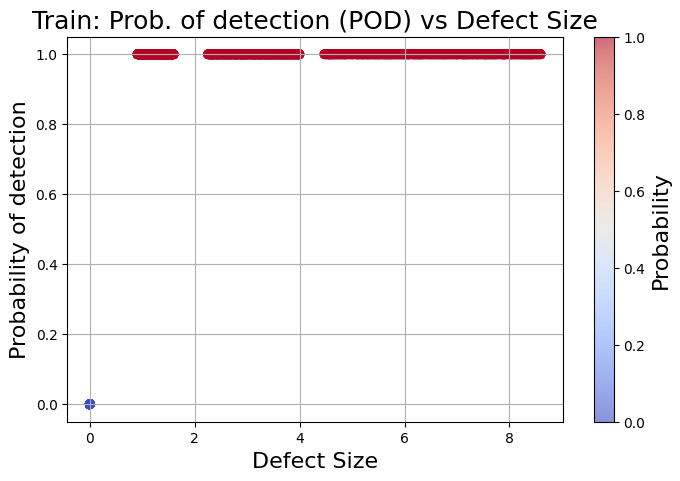

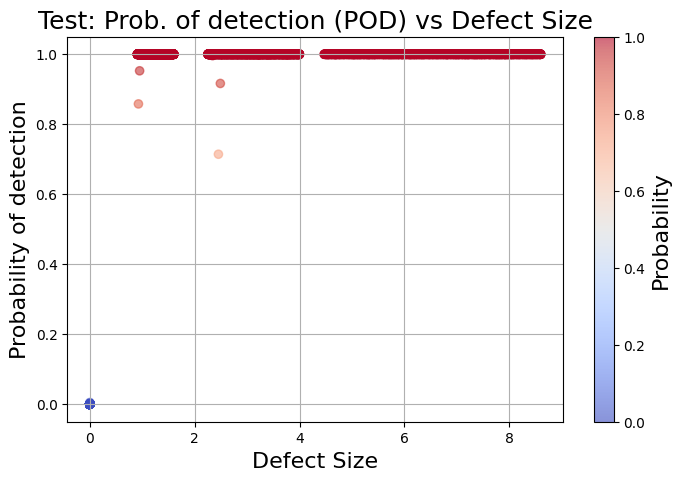

Epochs:  74%|███████▍  | 370/500 [1:30:25<31:58, 14.76s/it]

Epoch 371


Epochs:  74%|███████▍  | 371/500 [1:30:40<31:36, 14.70s/it]

Epoch 372


Epochs:  74%|███████▍  | 372/500 [1:30:54<31:16, 14.66s/it]

Epoch 373


Epochs:  75%|███████▍  | 373/500 [1:31:09<30:56, 14.62s/it]

Epoch 374


Epochs:  75%|███████▍  | 374/500 [1:31:23<30:40, 14.61s/it]

Epoch 375


Epochs:  75%|███████▌  | 375/500 [1:31:38<30:25, 14.60s/it]

Epoch 376


Epochs:  75%|███████▌  | 376/500 [1:31:52<30:10, 14.60s/it]

Epoch 377


Epochs:  75%|███████▌  | 377/500 [1:32:07<29:54, 14.59s/it]

Epoch 378


Epochs:  76%|███████▌  | 378/500 [1:32:22<29:38, 14.58s/it]

Epoch 379


Epochs:  76%|███████▌  | 379/500 [1:32:36<29:26, 14.60s/it]

Epoch 380


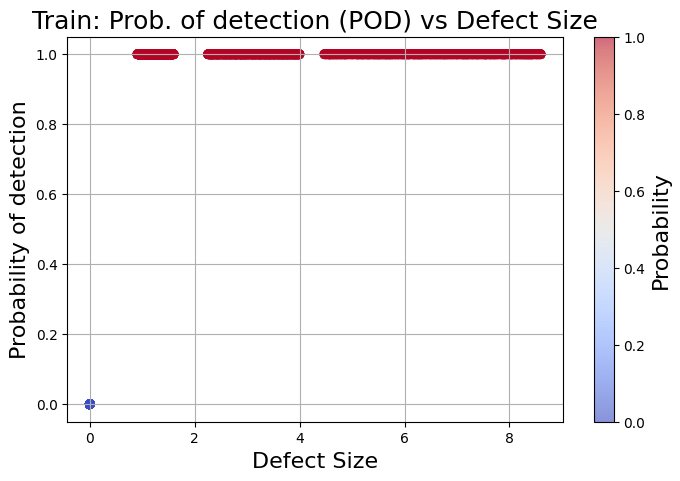

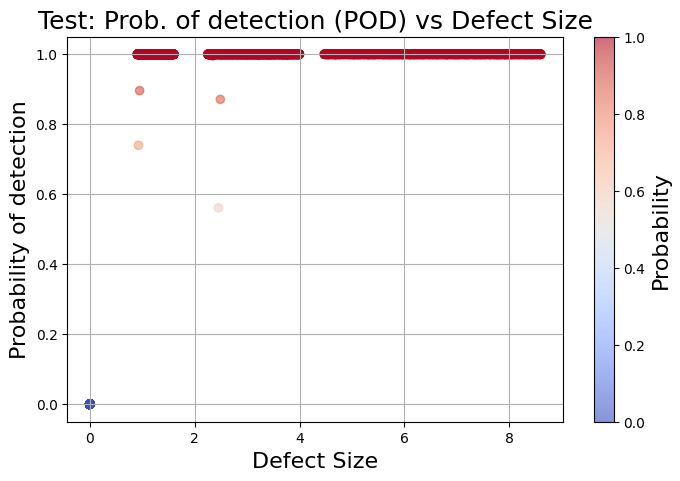

Epochs:  76%|███████▌  | 380/500 [1:32:51<29:33, 14.78s/it]

Epoch 381


Epochs:  76%|███████▌  | 381/500 [1:33:06<29:09, 14.70s/it]

Epoch 382


Epochs:  76%|███████▋  | 382/500 [1:33:20<28:48, 14.65s/it]

Epoch 383


Epochs:  77%|███████▋  | 383/500 [1:33:35<28:30, 14.62s/it]

Epoch 384


Epochs:  77%|███████▋  | 384/500 [1:33:50<28:14, 14.61s/it]

Epoch 385


Epochs:  77%|███████▋  | 385/500 [1:34:04<27:57, 14.59s/it]

Epoch 386


Epochs:  77%|███████▋  | 386/500 [1:34:19<27:42, 14.58s/it]

Epoch 387


Epochs:  77%|███████▋  | 387/500 [1:34:33<27:26, 14.57s/it]

Epoch 388


Epochs:  78%|███████▊  | 388/500 [1:34:48<27:12, 14.57s/it]

Epoch 389


Epochs:  78%|███████▊  | 389/500 [1:35:02<26:57, 14.57s/it]

Epoch 390


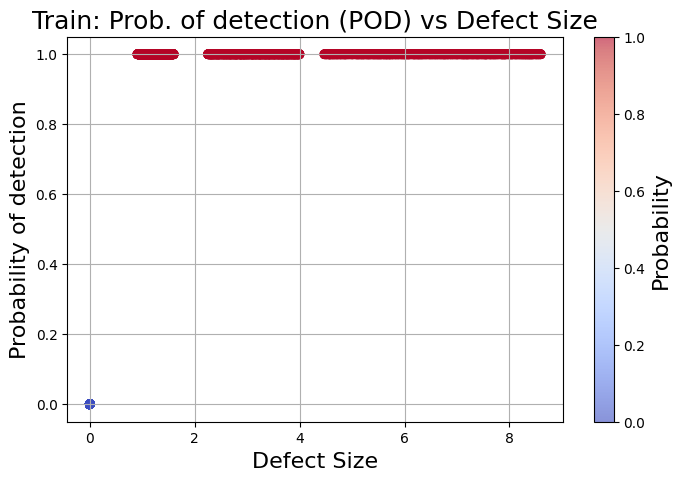

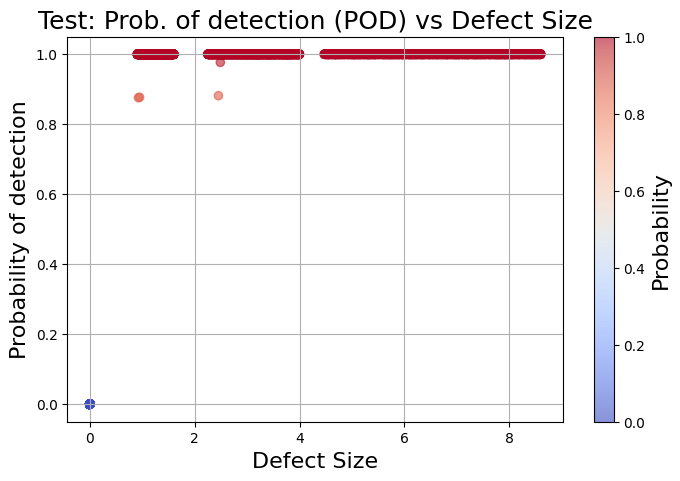

Epochs:  78%|███████▊  | 390/500 [1:35:18<27:04, 14.76s/it]

Epoch 391


Epochs:  78%|███████▊  | 391/500 [1:35:32<26:42, 14.70s/it]

Epoch 392


Epochs:  78%|███████▊  | 392/500 [1:35:47<26:22, 14.66s/it]

Epoch 393


Epochs:  79%|███████▊  | 393/500 [1:36:01<26:06, 14.64s/it]

Epoch 394


Epochs:  79%|███████▉  | 394/500 [1:36:16<25:49, 14.62s/it]

Epoch 395


Epochs:  79%|███████▉  | 395/500 [1:36:30<25:32, 14.60s/it]

Epoch 396


Epochs:  79%|███████▉  | 396/500 [1:36:45<25:16, 14.58s/it]

Epoch 397


Epochs:  79%|███████▉  | 397/500 [1:37:00<25:01, 14.58s/it]

Epoch 398


Epochs:  80%|███████▉  | 398/500 [1:37:14<24:47, 14.59s/it]

Epoch 399


Epochs:  80%|███████▉  | 399/500 [1:37:29<24:31, 14.57s/it]

Epoch 400


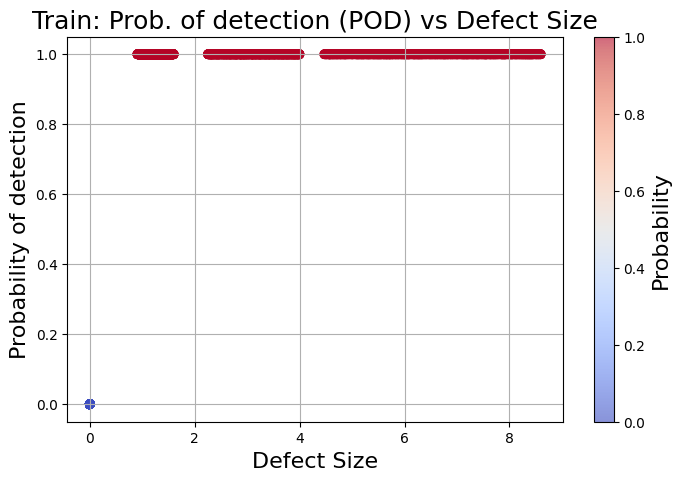

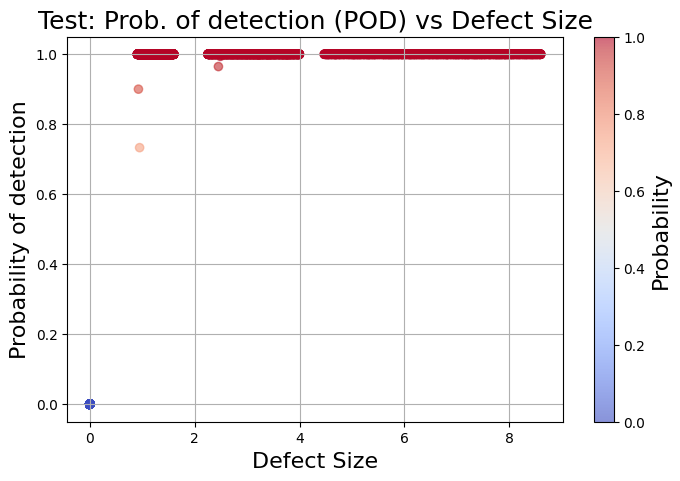

Epochs:  80%|████████  | 400/500 [1:37:44<24:36, 14.77s/it]

Epoch 401


Epochs:  80%|████████  | 401/500 [1:37:58<24:15, 14.70s/it]

Epoch 402


Epochs:  80%|████████  | 402/500 [1:38:13<23:56, 14.66s/it]

Epoch 403


Epochs:  81%|████████  | 403/500 [1:38:28<23:42, 14.66s/it]

Epoch 404


Epochs:  81%|████████  | 404/500 [1:38:42<23:24, 14.63s/it]

Epoch 405


Epochs:  81%|████████  | 405/500 [1:38:57<23:07, 14.60s/it]

Epoch 406


Epochs:  81%|████████  | 406/500 [1:39:11<22:51, 14.59s/it]

Epoch 407


Epochs:  81%|████████▏ | 407/500 [1:39:26<22:37, 14.60s/it]

Epoch 408


Epochs:  82%|████████▏ | 408/500 [1:39:41<22:22, 14.59s/it]

Epoch 409


Epochs:  82%|████████▏ | 409/500 [1:39:55<22:06, 14.58s/it]

Epoch 410


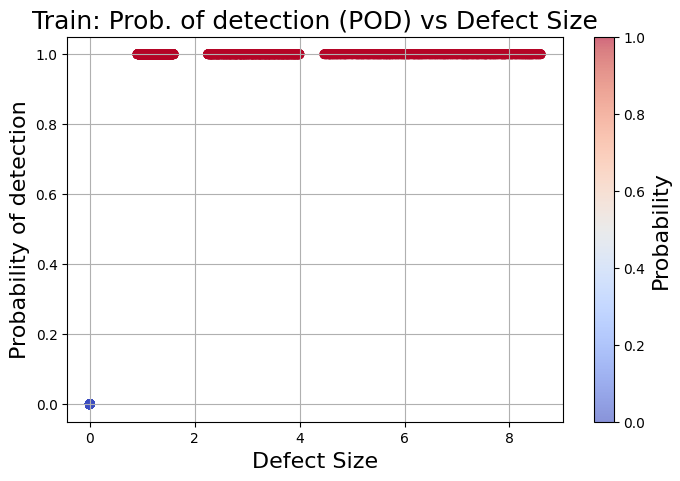

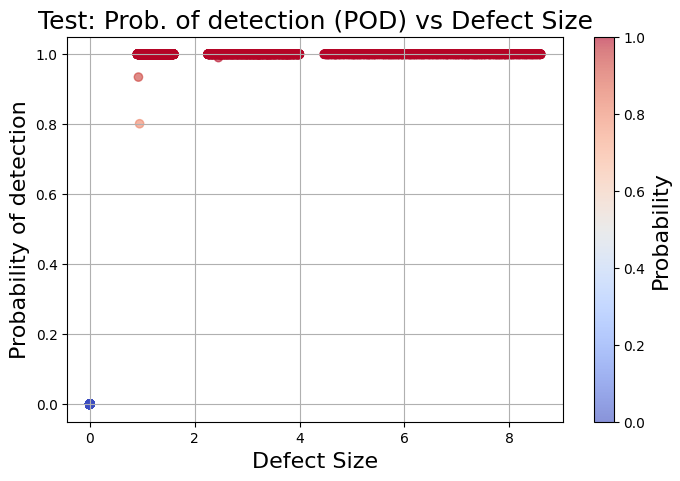

Epochs:  82%|████████▏ | 410/500 [1:40:10<22:09, 14.77s/it]

Epoch 411


Epochs:  82%|████████▏ | 411/500 [1:40:25<21:49, 14.71s/it]

Epoch 412


Epochs:  82%|████████▏ | 412/500 [1:40:40<21:32, 14.69s/it]

Epoch 413


Epochs:  83%|████████▎ | 413/500 [1:40:54<21:16, 14.67s/it]

Epoch 414


Epochs:  83%|████████▎ | 414/500 [1:41:09<20:58, 14.63s/it]

Epoch 415


Epochs:  83%|████████▎ | 415/500 [1:41:23<20:41, 14.60s/it]

Epoch 416


Epochs:  83%|████████▎ | 416/500 [1:41:38<20:28, 14.62s/it]

Epoch 417


Epochs:  83%|████████▎ | 417/500 [1:41:53<20:14, 14.63s/it]

Epoch 418


Epochs:  84%|████████▎ | 418/500 [1:42:07<19:59, 14.63s/it]

Epoch 419


Epochs:  84%|████████▍ | 419/500 [1:42:22<19:44, 14.63s/it]

Epoch 420


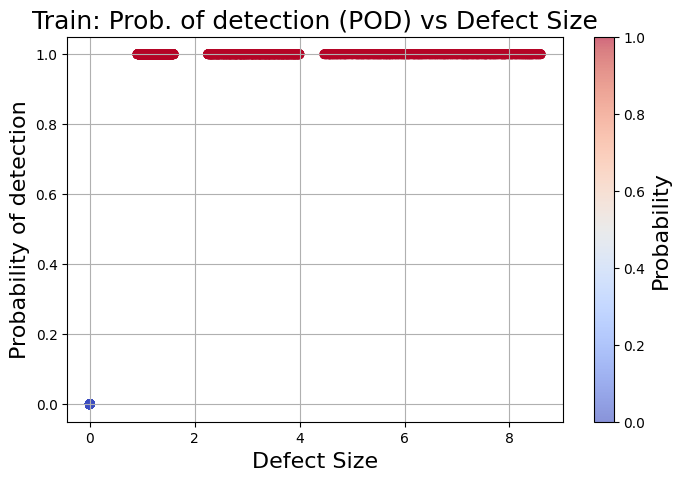

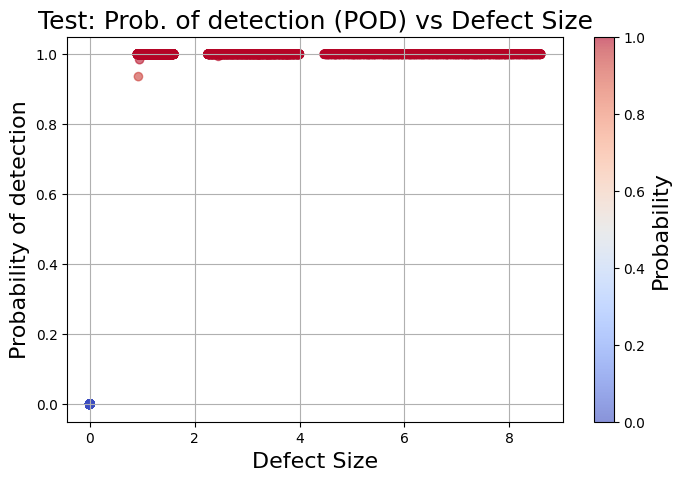

Epochs:  84%|████████▍ | 420/500 [1:42:37<19:43, 14.79s/it]

Epoch 421


Epochs:  84%|████████▍ | 421/500 [1:42:52<19:24, 14.74s/it]

Epoch 422


Epochs:  84%|████████▍ | 422/500 [1:43:06<19:06, 14.70s/it]

Epoch 423


Epochs:  85%|████████▍ | 423/500 [1:43:21<18:49, 14.67s/it]

Epoch 424


Epochs:  85%|████████▍ | 424/500 [1:43:35<18:34, 14.66s/it]

Epoch 425


Epochs:  85%|████████▌ | 425/500 [1:43:50<18:18, 14.64s/it]

Epoch 426


Epochs:  85%|████████▌ | 426/500 [1:44:05<18:03, 14.64s/it]

Epoch 427


Epochs:  85%|████████▌ | 427/500 [1:44:19<17:48, 14.64s/it]

Epoch 428


Epochs:  86%|████████▌ | 428/500 [1:44:34<17:32, 14.62s/it]

Epoch 429


Epochs:  86%|████████▌ | 429/500 [1:44:48<17:17, 14.62s/it]

Epoch 430


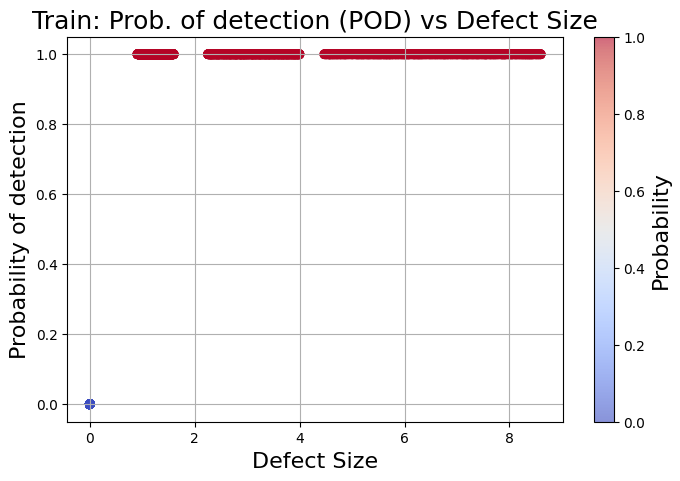

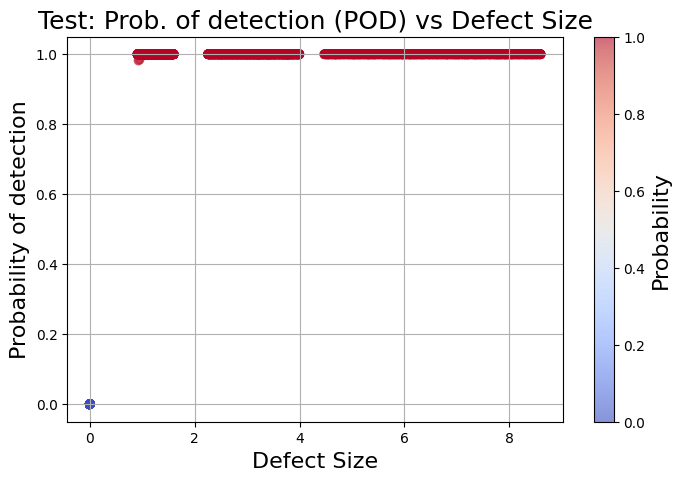

Epochs:  86%|████████▌ | 430/500 [1:45:04<17:16, 14.81s/it]

Epoch 431


Epochs:  86%|████████▌ | 431/500 [1:45:18<16:57, 14.74s/it]

Epoch 432


Epochs:  86%|████████▋ | 432/500 [1:45:33<16:39, 14.70s/it]

Epoch 433


Epochs:  87%|████████▋ | 433/500 [1:45:48<16:22, 14.66s/it]

Epoch 434


Epochs:  87%|████████▋ | 434/500 [1:46:02<16:05, 14.64s/it]

Epoch 435


Epochs:  87%|████████▋ | 435/500 [1:46:17<15:50, 14.63s/it]

Epoch 436


Epochs:  87%|████████▋ | 436/500 [1:46:31<15:35, 14.62s/it]

Epoch 437


Epochs:  87%|████████▋ | 437/500 [1:46:46<15:22, 14.64s/it]

Epoch 438


Epochs:  88%|████████▊ | 438/500 [1:47:01<15:06, 14.62s/it]

Epoch 439


Epochs:  88%|████████▊ | 439/500 [1:47:15<14:51, 14.62s/it]

Epoch 440


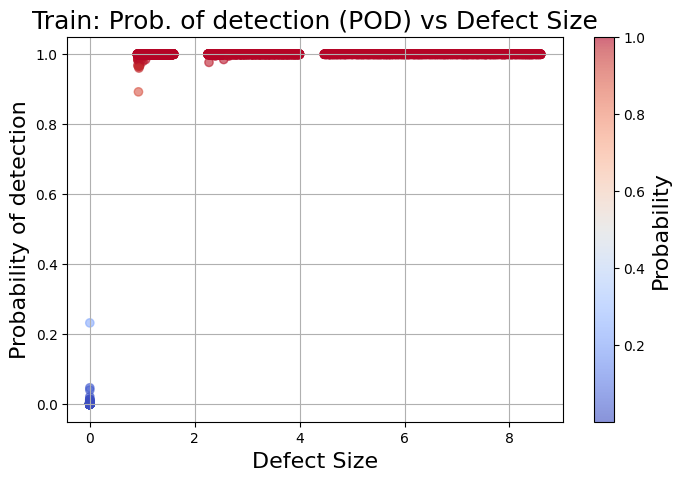

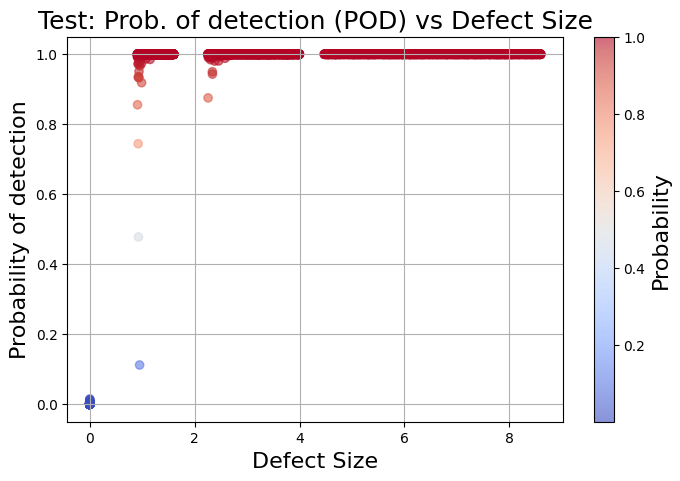

Epochs:  88%|████████▊ | 440/500 [1:47:30<14:48, 14.81s/it]

Epoch 441


Epochs:  88%|████████▊ | 441/500 [1:47:45<14:30, 14.75s/it]

Epoch 442


Epochs:  88%|████████▊ | 442/500 [1:48:00<14:13, 14.72s/it]

Epoch 443


Epochs:  89%|████████▊ | 443/500 [1:48:14<13:56, 14.68s/it]

Epoch 444


Epochs:  89%|████████▉ | 444/500 [1:48:29<13:41, 14.67s/it]

Epoch 445


Epochs:  89%|████████▉ | 445/500 [1:48:44<13:25, 14.64s/it]

Epoch 446


Epochs:  89%|████████▉ | 446/500 [1:48:58<13:11, 14.65s/it]

Epoch 447


Epochs:  89%|████████▉ | 447/500 [1:49:13<12:55, 14.63s/it]

Epoch 448


Epochs:  90%|████████▉ | 448/500 [1:49:27<12:41, 14.64s/it]

Epoch 449


Epochs:  90%|████████▉ | 449/500 [1:49:42<12:25, 14.61s/it]

Epoch 450


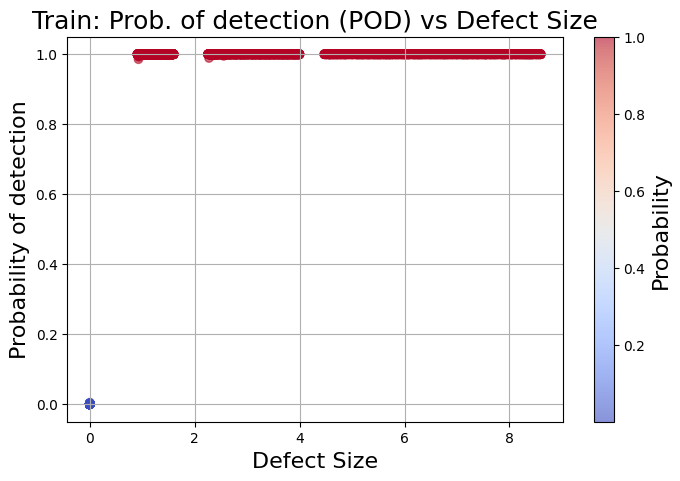

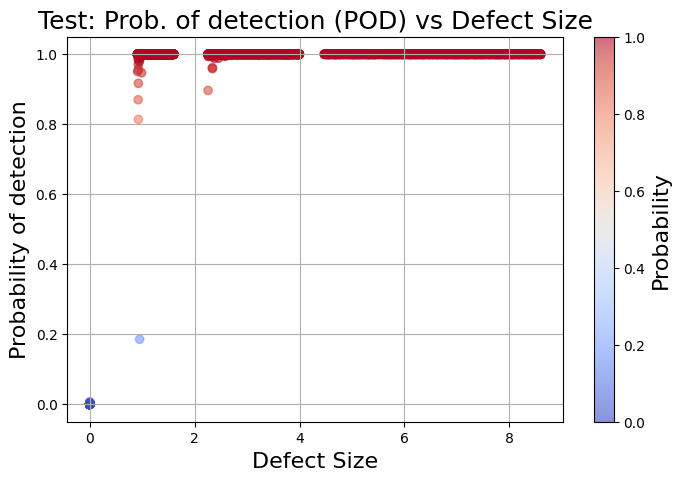

Epochs:  90%|█████████ | 450/500 [1:49:57<12:20, 14.80s/it]

Epoch 451


Epochs:  90%|█████████ | 451/500 [1:50:12<12:02, 14.74s/it]

Epoch 452


Epochs:  90%|█████████ | 452/500 [1:50:26<11:44, 14.68s/it]

Epoch 453


Epochs:  91%|█████████ | 453/500 [1:50:41<11:27, 14.63s/it]

Epoch 454


Epochs:  91%|█████████ | 454/500 [1:50:55<11:11, 14.61s/it]

Epoch 455


Epochs:  91%|█████████ | 455/500 [1:51:10<10:56, 14.59s/it]

Epoch 456


Epochs:  91%|█████████ | 456/500 [1:51:25<10:41, 14.59s/it]

Epoch 457


Epochs:  91%|█████████▏| 457/500 [1:51:39<10:27, 14.59s/it]

Epoch 458


Epochs:  92%|█████████▏| 458/500 [1:51:54<10:12, 14.58s/it]

Epoch 459


Epochs:  92%|█████████▏| 459/500 [1:52:08<09:57, 14.58s/it]

Epoch 460


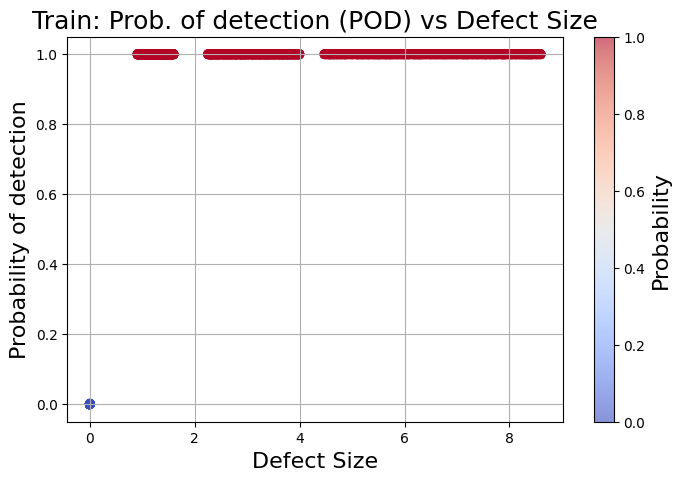

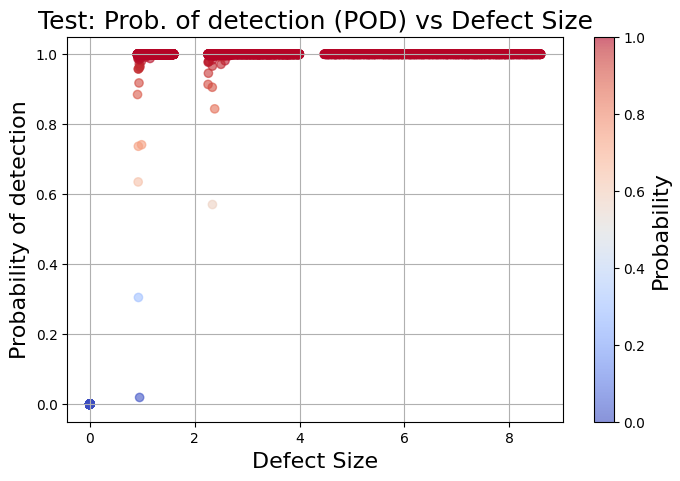

Epochs:  92%|█████████▏| 460/500 [1:52:24<09:51, 14.78s/it]

Epoch 461


Epochs:  92%|█████████▏| 461/500 [1:52:38<09:33, 14.72s/it]

Epoch 462


Epochs:  92%|█████████▏| 462/500 [1:52:53<09:18, 14.69s/it]

Epoch 463


Epochs:  93%|█████████▎| 463/500 [1:53:07<09:02, 14.67s/it]

Epoch 464


Epochs:  93%|█████████▎| 464/500 [1:53:22<08:46, 14.63s/it]

Epoch 465


Epochs:  93%|█████████▎| 465/500 [1:53:36<08:31, 14.62s/it]

Epoch 466


Epochs:  93%|█████████▎| 466/500 [1:53:51<08:16, 14.60s/it]

Epoch 467


Epochs:  93%|█████████▎| 467/500 [1:54:06<08:01, 14.58s/it]

Epoch 468


Epochs:  94%|█████████▎| 468/500 [1:54:20<07:46, 14.59s/it]

Epoch 469


Epochs:  94%|█████████▍| 469/500 [1:54:35<07:32, 14.60s/it]

Epoch 470


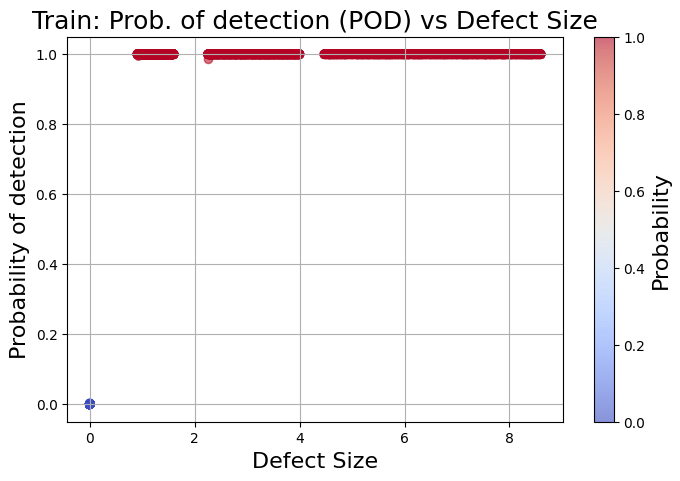

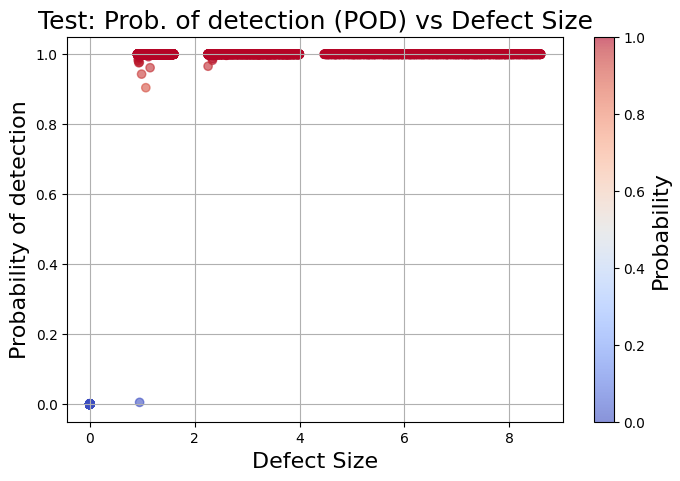

Epochs:  94%|█████████▍| 470/500 [1:54:50<07:23, 14.80s/it]

Epoch 471


Epochs:  94%|█████████▍| 471/500 [1:55:05<07:06, 14.71s/it]

Epoch 472


Epochs:  94%|█████████▍| 472/500 [1:55:19<06:50, 14.65s/it]

Epoch 473


Epochs:  95%|█████████▍| 473/500 [1:55:34<06:34, 14.61s/it]

Epoch 474


Epochs:  95%|█████████▍| 474/500 [1:55:48<06:19, 14.58s/it]

Epoch 475


Epochs:  95%|█████████▌| 475/500 [1:56:03<06:04, 14.58s/it]

Epoch 476


Epochs:  95%|█████████▌| 476/500 [1:56:17<05:49, 14.57s/it]

Epoch 477


Epochs:  95%|█████████▌| 477/500 [1:56:32<05:34, 14.55s/it]

Epoch 478


Epochs:  96%|█████████▌| 478/500 [1:56:46<05:19, 14.54s/it]

Epoch 479


Epochs:  96%|█████████▌| 479/500 [1:57:01<05:05, 14.53s/it]

Epoch 480


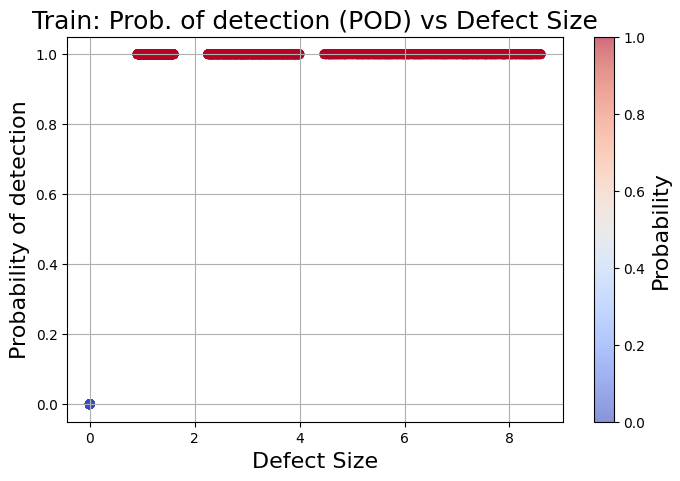

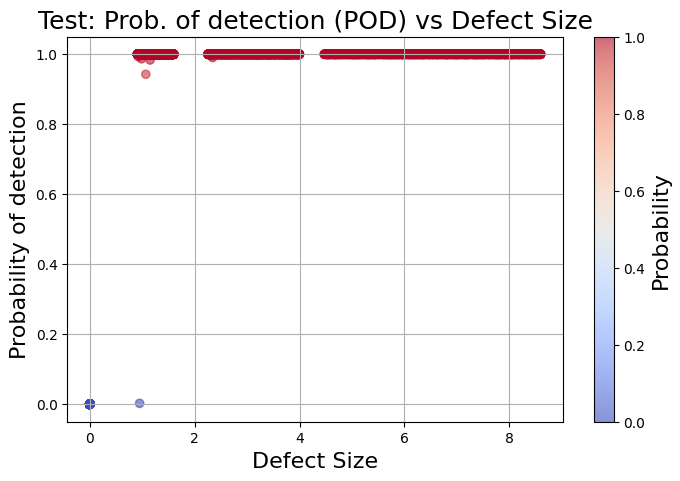

Epochs:  96%|█████████▌| 480/500 [1:57:16<04:56, 14.81s/it]

Epoch 481


Epochs:  96%|█████████▌| 481/500 [1:57:31<04:39, 14.72s/it]

Epoch 482


Epochs:  96%|█████████▋| 482/500 [1:57:45<04:23, 14.66s/it]

Epoch 483


Epochs:  97%|█████████▋| 483/500 [1:58:00<04:08, 14.62s/it]

Epoch 484


Epochs:  97%|█████████▋| 484/500 [1:58:14<03:53, 14.60s/it]

Epoch 485


Epochs:  97%|█████████▋| 485/500 [1:58:29<03:38, 14.59s/it]

Epoch 486


Epochs:  97%|█████████▋| 486/500 [1:58:43<03:24, 14.58s/it]

Epoch 487


Epochs:  97%|█████████▋| 487/500 [1:58:58<03:09, 14.56s/it]

Epoch 488


Epochs:  98%|█████████▊| 488/500 [1:59:13<02:54, 14.55s/it]

Epoch 489


Epochs:  98%|█████████▊| 489/500 [1:59:27<02:40, 14.55s/it]

Epoch 490


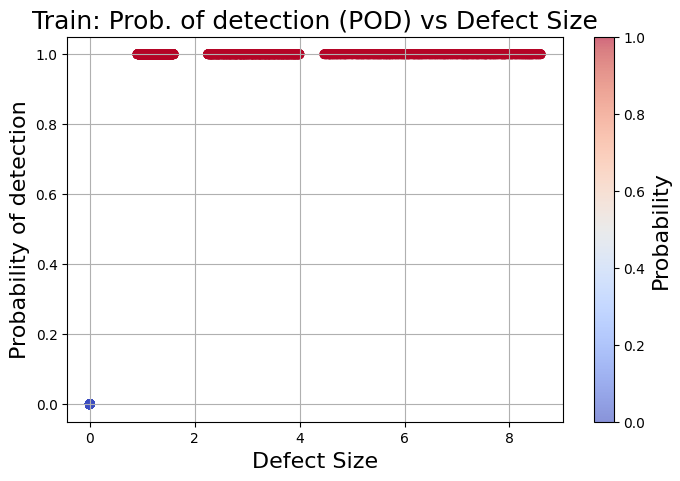

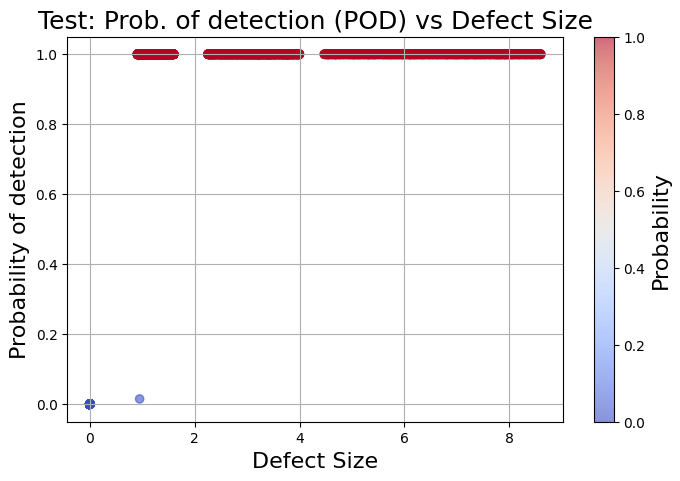

Epochs:  98%|█████████▊| 490/500 [1:59:42<02:27, 14.76s/it]

Epoch 491


Epochs:  98%|█████████▊| 491/500 [1:59:57<02:12, 14.69s/it]

Epoch 492


Epochs:  98%|█████████▊| 492/500 [2:00:11<01:57, 14.64s/it]

Epoch 493


Epochs:  99%|█████████▊| 493/500 [2:00:26<01:42, 14.59s/it]

Epoch 494


Epochs:  99%|█████████▉| 494/500 [2:00:40<01:27, 14.57s/it]

Epoch 495


Epochs:  99%|█████████▉| 495/500 [2:00:55<01:12, 14.56s/it]

Epoch 496


Epochs:  99%|█████████▉| 496/500 [2:01:09<00:58, 14.54s/it]

Epoch 497


Epochs:  99%|█████████▉| 497/500 [2:01:24<00:43, 14.52s/it]

Epoch 498


Epochs: 100%|█████████▉| 498/500 [2:01:38<00:29, 14.51s/it]

Epoch 499


Epochs: 100%|█████████▉| 499/500 [2:01:53<00:14, 14.51s/it]

Epoch 500


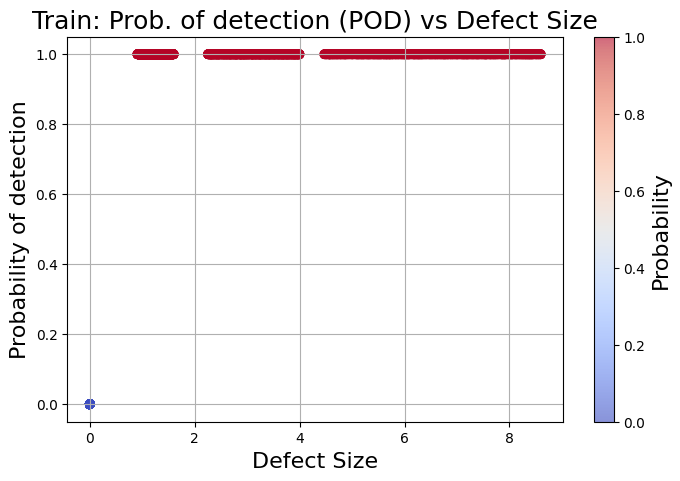

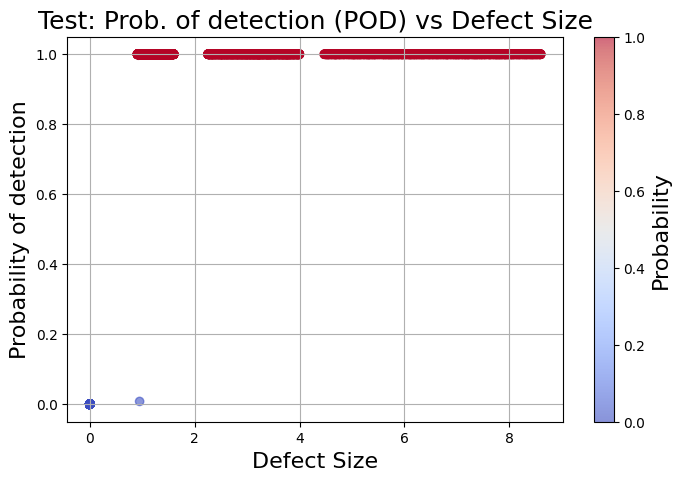

Epochs: 100%|██████████| 500/500 [2:02:08<00:00, 14.66s/it]


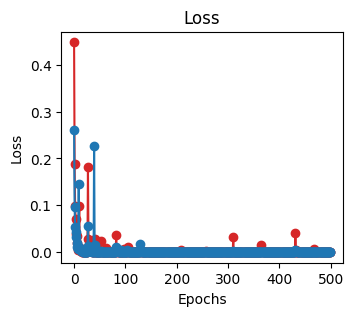

In [ ]:

# Initialize the neural network model.
model = UTModel(w = 256,h = 256,window =7 ).to(DEVICE)

# Define the loss function.
loss_func = nn.BCEWithLogitsLoss()  # because we output raw logit

# Define the neural network optimizer.
# Pass the optimizer the NN parameters so that it can update them.
optimizer = optim.Adam(model.parameters(), lr=0.0001) # <--- LEARNING RATE MIGHT BE GOOD TO EXPERIMENT WITH

# Record loss and accuracy for every epoch.
all_train_loss = []
all_defects_train = []
all_prob_train = []

all_test_loss = []
all_defects_test = []
all_prob_test = []

min_test_loss = np.inf

defects = np.empty( (0), dtype='float32')    #  defect lengths
probs = np.empty((0), dtype='float32')   #  probs data

# Train for some number of epochs.
num_epochs = 70

for epoch in tqdm(range(num_epochs), desc="Epochs"):

    print(f"Epoch {epoch+1}")

    # Initialize this epoch's loss results, defects and probs arrays.
    train_loss = 0.0
    test_loss = 0.0
    train_probs = np.empty((0), dtype='float32')   #  probs data
    test_probs = np.empty((0), dtype='float32')   #  probs data
    train_defects = np.empty( (0), dtype='float32')    #  defect lengths
    test_defects = np.empty( (0), dtype='float32')    #  defect lengths

    # Prepare the model for training.
    model.train()
    # Iterate over all images in the train loader to train the model.
    for images, labels, defect_sizes_train in train_loader:

        # Load the data onto the GPU.
        images = images.to(DEVICE)
        labels = labels.unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()           # zero the gradient buffers

        #predlabels, preddamage = model(images)            # pass the images through the model
        predlabels = model(images)            # pass the images through the model
        loss = loss_func(predlabels, labels)

        train_loss += loss.item()       # record the loss
        loss.backward()                 # compute gradients
        optimizer.step()                # update the model weights

        # Convert labels to probabilitiy
        tr_probs = logits_to_sigmoid_probs(predlabels.squeeze())

        train_defects = np.concatenate((train_defects,defect_sizes_train.cpu().detach().numpy()) )
        train_probs = np.concatenate((train_probs,tr_probs.cpu().detach().numpy()) )
        #
        #
    # Prepare the model for testing.
    model.eval()
    with torch.no_grad():  # Disable gradient calculation during testing
      # Iterate over all images in the test loader to test the model.
      for imagesT, labelsT, defect_sizes_test in test_loader:

        # Load the data onto the GPU.
        imagesT = imagesT.to(DEVICE)
        labelsT = labelsT.unsqueeze(1).to(DEVICE)
        predlabelsT = model(imagesT)            # pass the images through the model
        loss = loss_func(predlabelsT, labelsT)

        test_loss += loss.item()       # record the loss

        # Convert labels to probabilitiy
        tst_probs = logits_to_sigmoid_probs(predlabelsT.squeeze())

        test_defects = np.concatenate((test_defects,defect_sizes_test.cpu().detach().numpy()) )
        test_probs = np.concatenate((test_probs,tst_probs.cpu().detach().numpy()) )
        #
        #

    # Record the average loss across batches for this epoch.
    all_train_loss.append(train_loss / len(train_loader))
    all_test_loss.append(test_loss / len(test_loader))

    # Add probs and defects for  this epoch.
    all_defects_train.append(train_defects)
    all_prob_train.append(train_probs)
    all_defects_test.append(test_defects)
    all_prob_test.append(test_probs)

    # plot training and test data every 10 epochs
    if (epoch + 1) % 10 == 0:
        #defects vs probs for every 10th epoch
        plot_single_prob_vs_defect_size(train_probs, train_defects, title="Train: Prob. of detection (POD) vs Defect Size")
        plot_single_prob_vs_defect_size(test_probs, test_defects, title="Test: Prob. of detection (POD) vs Defect Size")

# Save the training and testing data to a file
now = datetime.datetime.now(pytz.timezone('America/Los_Angeles'))
date_time_str = now.strftime("%m%d_%H%M")

filename = f'/content/drive/MyDrive/engr521_dataset/training_loss_probs/training_testing_data_b32_epoch_{num_epochs}_{date_time_str}.npz'
np.savez(filename,
         all_train_loss=all_train_loss,
         all_test_loss=all_test_loss,
         all_defects_train=all_defects_train,
         all_prob_train=all_prob_train,
         all_defects_test=all_defects_test,
         all_prob_test=all_prob_test)


# Plot the loss and accuracy across epochs.
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(all_train_loss, "o-", c="tab:red", label='Training Loss')
plt.plot(all_test_loss, "o-", c="tab:blue", label='Test Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss")

plt.show()

## Loss histories

Plotting training and test losses every 5th Epoch

Training loss sampled every 5th epoch: [0.44797829062508315, 0.01976161211384639, 0.0985950863949535, 0.001453607543691016, 0.0003184808573454569, 0.00011632700114077511, 0.007112755568678708, 0.0013493204104119746, 0.027262561694488187, 5.1744842612145305e-05, 3.3128084039098135e-05, 0.0003453791101752306, 8.277380416997745e-05, 4.538282689793414e-05, 1.216069536700835e-05, 2.317742591081401e-06, 1.798102033467312e-06, 0.0017836153687248691, 0.0004008731922191384, 8.698766418420766e-05, 0.0001711669863437763, 0.010773723671210331, 4.2246116142193615e-05, 2.12691106210473e-05, 8.680222109246148e-06, 3.7878893840650587e-06, 0.0017203394404453095, 0.00011459346194986714, 1.8902775847547749e-06, 1.209500555542935e-06, 7.850062485243867e-07, 4.4001467147984976e-07, 1.051966313287995e-07, 4.2425304318368545e-08, 2.2868457877390185e-08, 1.3449073638049809e-08, 9.936849341587986e-09, 2.308883189402123e-09, 1.0507315778958028e-09, 4.1088095097016325e-10, 1.8354755901050612e-10, 1.5538585418589

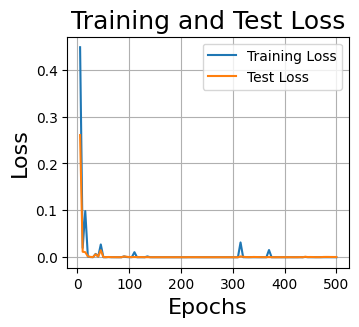

In [ ]:
#Print loss every 5th epoch
print(f"Training loss sampled every 5th epoch: {all_train_loss[::5]}")
print(f"Test loss sampled every 5th epoch: {all_test_loss[::5]}")

#Plot training and test loses Every 5th Epoch
epochs_to_plot = list(range(5, num_epochs + 1, 5))
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_to_plot, all_train_loss[::5], label='Training Loss') # Plot training loss
plt.plot(epochs_to_plot, all_test_loss[::5], label='Test Loss') # Plot test loss
#plt.semilogy(epochs_to_plot, all_train_loss[::5], label='Training Loss') # Plot training loss
#plt.semilogy(epochs_to_plot, all_test_loss[::5], label='Test Loss') # Plot test loss


plt.title("Training and Test Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()